In [0]:
import csv
import random
import time
import math
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets


from random import shuffle
from collections import defaultdict
from copy import deepcopy
from itertools import chain


from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler


In [0]:
# The below code implements Optimizer class and is taken from pytorch's github implementation

required = object()


class Optimizer(object):
    """Base class for all optimizers.

    Arguments:
        params (iterable): an iterable of :class:`Variable` s or
            :class:`dict` s. Specifies what Variables should be optimized.
        defaults: (dict): a dict containing default values of optimization
            options (used when a parameter group doesn't specify them).
    """

    def __init__(self, params, defaults):
        self.defaults = defaults

        if isinstance(params, Variable) or torch.is_tensor(params):
            raise TypeError("params argument given to the optimizer should be "
                            "an iterable of Variables or dicts, but got " +
                            torch.typename(params))

        self.state = defaultdict(dict)
        self.param_groups = []

        param_groups = list(params)
        if len(param_groups) == 0:
            raise ValueError("optimizer got an empty parameter list")
        if not isinstance(param_groups[0], dict):
            param_groups = [{'params': param_groups}]

        for param_group in param_groups:
            self.add_param_group(param_group)

    def __getstate__(self):
        return {
            'state': self.state,
            'param_groups': self.param_groups,
        }

    def __setstate__(self, state):
        self.__dict__.update(state)

    def state_dict(self):
        """Returns the state of the optimizer as a :class:`dict`.

        It contains two entries:

        * state - a dict holding current optimization state. Its content
            differs between optimizer classes.
        * param_groups - a dict containing all parameter groups
        """
        # Save ids instead of Variables
        def pack_group(group):
            packed = {k: v for k, v in group.items() if k != 'params'}
            packed['params'] = [id(p) for p in group['params']]
            return packed
        param_groups = [pack_group(g) for g in self.param_groups]
        # Remap state to use ids as keys
        packed_state = {(id(k) if isinstance(k, Variable) else k): v
                        for k, v in self.state.items()}
        return {
            'state': packed_state,
            'param_groups': param_groups,
        }

    def load_state_dict(self, state_dict):
        """Loads the optimizer state.

        Arguments:
            state_dict (dict): optimizer state. Should be an object returned
                from a call to :meth:`state_dict`.
        """
        # deepcopy, to be consistent with module API
        state_dict = deepcopy(state_dict)
        # Validate the state_dict
        groups = self.param_groups
        saved_groups = state_dict['param_groups']

        if len(groups) != len(saved_groups):
            raise ValueError("loaded state dict has a different number of "
                             "parameter groups")
        param_lens = (len(g['params']) for g in groups)
        saved_lens = (len(g['params']) for g in saved_groups)
        if any(p_len != s_len for p_len, s_len in zip(param_lens, saved_lens)):
            raise ValueError("loaded state dict contains a parameter group "
                             "that doesn't match the size of optimizer's group")

        # Update the state
        id_map = {old_id: p for old_id, p in
                  zip(chain(*(g['params'] for g in saved_groups)),
                      chain(*(g['params'] for g in groups)))}
        state = defaultdict(
            dict, {id_map.get(k, k): v for k, v in state_dict['state'].items()})

        # Update parameter groups, setting their 'params' value
        def update_group(group, new_group):
            new_group['params'] = group['params']
            return new_group
        param_groups = [
            update_group(g, ng) for g, ng in zip(groups, saved_groups)]
        self.__setstate__({'state': state, 'param_groups': param_groups})

    def zero_grad(self):
        """Clears the gradients of all optimized :class:`Variable` s."""
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    if p.grad.volatile:
                        p.grad.data.zero_()
                    else:
                        data = p.grad.data
                        p.grad = Variable(data.new().resize_as_(data).zero_())

    def step(self, closure):
        """Performs a single optimization step (parameter update).

        Arguments:
            closure (callable): A closure that reevaluates the model and
                returns the loss. Optional for most optimizers.
        """
        raise NotImplementedError

    def add_param_group(self, param_group):
        """Add a param group to the :class:`Optimizer` s `param_groups`.

        This can be useful when fine tuning a pre-trained network as frozen layers can be made
        trainable and added to the :class:`Optimizer` as training progresses.

        Arguments:
            param_group (dict): Specifies what Variables should be optimized along with group
            specific optimization options.
        """
        assert isinstance(param_group, dict), "param group must be a dict"

        params = param_group['params']
        if isinstance(params, Variable):
            param_group['params'] = [params]
        else:
            param_group['params'] = list(params)

        for param in param_group['params']:
            if not isinstance(param, Variable):
                raise TypeError("optimizer can only optimize Variables, "
                                "but one of the params is " + torch.typename(param))
            if not param.requires_grad:
                raise ValueError("optimizing a parameter that doesn't require gradients")
            if not param.is_leaf:
                raise ValueError("can't optimize a non-leaf Variable")

        for name, default in self.defaults.items():
            if default is required and name not in param_group:
                raise ValueError("parameter group didn't specify a value of required optimization parameter " +
                                 name)
            else:
                param_group.setdefault(name, default)

        param_set = set()
        for group in self.param_groups:
            param_set.update(set(group['params']))

        if not param_set.isdisjoint(set(param_group['params'])):
            raise ValueError("some parameters appear in more than one parameter group")

        self.param_groups.append(param_group)


In [0]:
# The below code modifies pytorch implementation of Adams optimizer to implement Amsgrad algorithm removing the bias correction step

class Amsgrad(Optimizer):
    """Implements Amsgrad algorithm.

    It has been proposed in `On the Convergence of Adam and Beyond`_.

    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)

    .. _n the Convergence of Adam and Beyond:
        https://openreview.net/forum?id=ryQu7f-RZ
    """

    # constructor to initialize the hyper-parameters
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.99), eps=1e-8,
                 weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay)
        super(Amsgrad, self).__init__(params, defaults)

    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Amsgrad does not support sparse gradients, please consider SparseAdam instead')

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    # Maximum exponential moving average of squared gradient values
                    state['exp_avg_sq_maximum'] = torch.zeros_like(p.data)
                exp_avg, exp_avg_sq, exp_avg_sq_maximum = state['exp_avg'], state['exp_avg_sq'], state['exp_avg_sq_maximum']
                beta1, beta2 = group['betas']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

               # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                
                # Calculate the maximum between the previous maximum exponential average of squared gradients and current value
                exp_avg_sq_maximum = torch.max(exp_avg_sq_maximum,exp_avg_sq)

                # Store the maximum
                state['exp_avg_sq_maximum'] = exp_avg_sq_maximum
                
                
                denom = exp_avg_sq_maximum.sqrt().add_(group['eps'])

               
                step_size = group['lr']
                
                
                # Performs update on parameters of the network based on gradients
                p.data.addcdiv_(-step_size, exp_avg, denom)

        return loss


In [44]:
'''
Reading CIFAR-10 dataset
'''

valid_size = 0.0
num_train_hyp = 5000
num_valid_hyp = 1000
batch_size = 128

# It converts the datapoints into tensor and then normalise each datapoint with given mean and standard deviation 
transform = transforms.Compose([transforms.ToTensor(),
                            transforms.Normalize([0.5,], [0.5,])])

# Loading the  CIFAR-10 dataset consisting of 50000 colored training images and 10000 colored testing images of size 32 X 32 pixels in a batch size of 128 images at a time
# and performing the above transformations 
# Randomly splitting data into 5000 training examples and 1000 validation examples by generating 50000 random unique indices in the range [0,49999] and then retreiving the initial 5000 values at those indices for building the training dataset. The values at following 1000 indices are used for building validation dataset.
trainset_cifar_10 = datasets.CIFAR10('./', train=True, transform=transform, download=True)
num_train = len(trainset_cifar_10)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_idx_hyp, valid_idx_hyp = indices[num_valid_hyp:num_valid_hyp+num_train_hyp], indices[:num_valid_hyp]

train_sampler_cifar = SubsetRandomSampler(train_idx)
valid_sampler_cifar = SubsetRandomSampler(valid_idx)

train_sampler_cifar_hyp = SubsetRandomSampler(train_idx_hyp)
valid_sampler_cifar_hyp = SubsetRandomSampler(valid_idx_hyp)

trainloader_cifar_10 = torch.utils.data.DataLoader(trainset_cifar_10, batch_size=batch_size, sampler=train_sampler_cifar)
validloader_cifar_10 = torch.utils.data.DataLoader(trainset_cifar_10, batch_size=batch_size, sampler=valid_sampler_cifar)


trainloader_cifar_hyp = torch.utils.data.DataLoader(trainset_cifar_10, batch_size=batch_size, sampler=train_sampler_cifar_hyp)
validloader_cifar_hyp = torch.utils.data.DataLoader(trainset_cifar_10, batch_size=batch_size, sampler=valid_sampler_cifar_hyp)

testset_cifar_10 = torchvision.datasets.CIFAR10(root='./', train=False, download=True, transform=transform)
testloader_cifar_10 = torch.utils.data.DataLoader(testset_cifar_10, batch_size=128, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
num_batches_train = int((1-valid_size)*num_train/batch_size)
num_batches_valid = int(valid_size*num_train/batch_size)
num_batches_train_hyp = int(num_train_hyp/batch_size)
num_batches_valid_hyp = int(num_valid_hyp/batch_size)
num_batches_test = int(len(testset_cifar_10)/batch_size)

In [7]:
num_batches_train, num_batches_valid, num_batches_train_hyp, num_batches_valid_hyp, num_batches_test

(390, 0, 39, 7, 78)

In [47]:
# Cifar architecture based on our understanding of the paper
#1) 2 Conv layers with 64 output channels
#2) Size of filter for every conv layer is 6 in length and width and for Max-pooling layer, it is 2,2
#3) Padding is set to 2 with stride of 1
#4) 2 Fully connected layers with 384 and 192 units
#5) Batch normalization layers is done after first pool layer 
#6) Dropout is introduced to randomly turn on 50% of activation units in the FC-1 layer.
#7) The ouput layer gives raw scores for every class for every input.
#8) ReLU activation has been used to ensure that there is no Vanishing gradient issue



class CifarNet(nn.Module):
  
  def __init__(self):
    super(CifarNet, self).__init__()
    
    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size=(6,6), stride=(1,1), padding=2)
    self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
    self.bn1 = nn.BatchNorm2d(64)
    
    self.conv2 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size=(6,6), stride=(1,1), padding=2)

    
    self.fc1 = nn.Linear(64*14*14, 384)
    
    self.fc2 = nn.Linear(384, 192)

    self.fc3 = nn.Linear(192,10)
    
  def forward(self,x):
    
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = self.bn1(x)
    
    x = F.relu(self.conv2(x))

    x = x.view(-1, 64*14*14)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, p=0.5)
    
    x = F.relu(self.fc2(x))

    x = self.fc3(x)
    return x

SyntaxError: ignored

In [0]:
## Instanstiating the network on GPU
net = CifarNet()
initial_state = net.state_dict()
net = net.cuda()

In [10]:
print(net)

CifarNet(
  (conv1): Conv2d (3, 64, kernel_size=(6, 6), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (conv2): Conv2d (64, 64, kernel_size=(6, 6), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=12544, out_features=384)
  (fc2): Linear(in_features=384, out_features=192)
  (fc3): Linear(in_features=192, out_features=10)
)


In [0]:
# Learning the parameters using Amsgrad optimization with categorical cross-entropy loss. The learning rate is initially set to 0.001.
criterion = nn.CrossEntropyLoss()
alphas = np.geomspace(1e-4,1e-6, num=7)
betas = [0.99, 0.992, 0.994, 0.995, 0.996, 0.998, 0.999]

In [12]:
alphas

array([1.00000000e-04, 4.64158883e-05, 2.15443469e-05, 1.00000000e-05,
       4.64158883e-06, 2.15443469e-06, 1.00000000e-06])

In [0]:
# The function validation_loss() calculates the loss on validation data which is shuffled and passed to the network in batch size of 128 instances after every epoch.
def validation_loss(validloader, num_batches_valid, net_, criterion_):
  running_valid_loss = 0.0
  for i, data in enumerate(validloader, 0):
      inputs, labels = data
      inputs = inputs.float()
      labels = labels.long()
      inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())


      valid_output = net_(inputs)
      loss_valid = criterion_(valid_output, labels)

      # print statistics
      running_valid_loss += loss_valid.data[0]
   
  return (running_valid_loss / num_batches_valid)

In [14]:
#Hyper-parameter tuning for AMSGrad for alpha and beta2 using trainig set of 5000 examples and validation set of 1000 examples for 15 epochs for a total of 49 hyper-parameter combinations

train_loss_list = []
valid_loss_list = []
for alpha in alphas:
  for beta in betas:
    train_loss_list.append(([], alpha, beta))
    valid_loss_list.append(([], alpha, beta))

num_epochs = 15
total_combo = len(alphas)*len(betas)

param_combo_count = 0
for alpha in alphas:
  for beta in betas:
    print("alpha:", alpha, " beta 2: ", beta)
    print("Parameter Combination:", param_combo_count+1, "/", total_combo)
    net.load_state_dict(initial_state)
    optimizer = Amsgrad(net.parameters(), lr=alpha, betas=(0.9,beta))
    start_time_combo = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss_train = 0.0
        for i, data in enumerate(trainloader_cifar_hyp, 0):
            # get the inputs
            inputs, labels = data

            # wrap them in Variable
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # print statistics
            running_loss_train += loss.data[0]
        
        train_loss = running_loss_train/num_batches_train_hyp
        valid_loss = validation_loss(validloader_cifar_hyp, num_batches_valid_hyp, net, criterion)
        print ('Epoch: %d Train loss: %.3f' %(epoch + 1, train_loss))
        print ('Epoch: %d Valid loss: %.3f' %(epoch + 1, valid_loss))
        train_loss_list[param_combo_count][0].append(train_loss)
        valid_loss_list[param_combo_count][0].append(valid_loss)

    elapsed_time = time.time() - start_time_combo
    print('Finished Training') 
    print("Time for 1 combination of hyper-parameters: ", elapsed_time)
    param_combo_count += 1
 

alpha: 0.0001  beta 2:  0.99
Parameter Combination: 1 / 49
Epoch: 1 Train loss: 1.946
Epoch: 1 Valid loss: 1.873
Epoch: 2 Train loss: 1.536
Epoch: 2 Valid loss: 1.635
Epoch: 3 Train loss: 1.376
Epoch: 3 Valid loss: 1.439
Epoch: 4 Train loss: 1.229
Epoch: 4 Valid loss: 1.316
Epoch: 5 Train loss: 1.125
Epoch: 5 Valid loss: 1.232
Epoch: 6 Train loss: 1.084
Epoch: 6 Valid loss: 1.155
Epoch: 7 Train loss: 1.017
Epoch: 7 Valid loss: 1.035
Epoch: 8 Train loss: 0.898
Epoch: 8 Valid loss: 0.958
Epoch: 9 Train loss: 0.814
Epoch: 9 Valid loss: 0.872
Epoch: 10 Train loss: 0.794
Epoch: 10 Valid loss: 0.811
Epoch: 11 Train loss: 0.729
Epoch: 11 Valid loss: 0.787
Epoch: 12 Train loss: 0.663
Epoch: 12 Valid loss: 0.681
Epoch: 13 Train loss: 0.594
Epoch: 13 Valid loss: 0.601
Epoch: 14 Train loss: 0.540
Epoch: 14 Valid loss: 0.541
Epoch: 15 Train loss: 0.481
Epoch: 15 Valid loss: 0.502
Finished Training
Time for 1 combination of hyper-parameters:  33.45648527145386
alpha: 0.0001  beta 2:  0.992
Paramete

Epoch: 15 Train loss: 0.811
Epoch: 15 Valid loss: 0.873
Finished Training
Time for 1 combination of hyper-parameters:  43.77749586105347
alpha: 4.641588833612782e-05  beta 2:  0.996
Parameter Combination: 12 / 49
Epoch: 1 Train loss: 2.020
Epoch: 1 Valid loss: 1.927
Epoch: 2 Train loss: 1.622
Epoch: 2 Valid loss: 1.696
Epoch: 3 Train loss: 1.456
Epoch: 3 Valid loss: 1.563
Epoch: 4 Train loss: 1.368
Epoch: 4 Valid loss: 1.472
Epoch: 5 Train loss: 1.283
Epoch: 5 Valid loss: 1.377
Epoch: 6 Train loss: 1.201
Epoch: 6 Valid loss: 1.297
Epoch: 7 Train loss: 1.145
Epoch: 7 Valid loss: 1.253
Epoch: 8 Train loss: 1.114
Epoch: 8 Valid loss: 1.202
Epoch: 9 Train loss: 1.046
Epoch: 9 Valid loss: 1.139
Epoch: 10 Train loss: 0.995
Epoch: 10 Valid loss: 1.105
Epoch: 11 Train loss: 0.962
Epoch: 11 Valid loss: 1.041
Epoch: 12 Train loss: 0.918
Epoch: 12 Valid loss: 1.001
Epoch: 13 Train loss: 0.874
Epoch: 13 Valid loss: 0.947
Epoch: 14 Train loss: 0.817
Epoch: 14 Valid loss: 0.919
Epoch: 15 Train loss:

Epoch: 12 Train loss: 1.542
Epoch: 12 Valid loss: 1.734
Epoch: 13 Train loss: 1.529
Epoch: 13 Valid loss: 1.723
Epoch: 14 Train loss: 1.493
Epoch: 14 Valid loss: 1.692
Epoch: 15 Train loss: 1.483
Epoch: 15 Valid loss: 1.672
Finished Training
Time for 1 combination of hyper-parameters:  43.35505414009094
alpha: 1e-05  beta 2:  0.992
Parameter Combination: 23 / 49
Epoch: 1 Train loss: 2.301
Epoch: 1 Valid loss: 2.442
Epoch: 2 Train loss: 2.087
Epoch: 2 Valid loss: 2.200
Epoch: 3 Train loss: 1.912
Epoch: 3 Valid loss: 2.077
Epoch: 4 Train loss: 1.820
Epoch: 4 Valid loss: 2.006
Epoch: 5 Train loss: 1.751
Epoch: 5 Valid loss: 1.942
Epoch: 6 Train loss: 1.717
Epoch: 6 Valid loss: 1.906
Epoch: 7 Train loss: 1.675
Epoch: 7 Valid loss: 1.867
Epoch: 8 Train loss: 1.639
Epoch: 8 Valid loss: 1.831
Epoch: 9 Train loss: 1.615
Epoch: 9 Valid loss: 1.796
Epoch: 10 Train loss: 1.589
Epoch: 10 Valid loss: 1.775
Epoch: 11 Train loss: 1.559
Epoch: 11 Valid loss: 1.740
Epoch: 12 Train loss: 1.530
Epoch: 12

Epoch: 12 Train loss: 1.692
Epoch: 12 Valid loss: 1.893
Epoch: 13 Train loss: 1.667
Epoch: 13 Valid loss: 1.882
Epoch: 14 Train loss: 1.642
Epoch: 14 Valid loss: 1.859
Epoch: 15 Train loss: 1.639
Epoch: 15 Valid loss: 1.840
Finished Training
Time for 1 combination of hyper-parameters:  43.32974195480347
alpha: 4.641588833612782e-06  beta 2:  0.998
Parameter Combination: 34 / 49
Epoch: 1 Train loss: 2.312
Epoch: 1 Valid loss: 2.473
Epoch: 2 Train loss: 2.128
Epoch: 2 Valid loss: 2.252
Epoch: 3 Train loss: 1.967
Epoch: 3 Valid loss: 2.124
Epoch: 4 Train loss: 1.868
Epoch: 4 Valid loss: 2.051
Epoch: 5 Train loss: 1.813
Epoch: 5 Valid loss: 1.996
Epoch: 6 Train loss: 1.763
Epoch: 6 Valid loss: 1.951
Epoch: 7 Train loss: 1.735
Epoch: 7 Valid loss: 1.921
Epoch: 8 Train loss: 1.702
Epoch: 8 Valid loss: 1.899
Epoch: 9 Train loss: 1.664
Epoch: 9 Valid loss: 1.868
Epoch: 10 Train loss: 1.656
Epoch: 10 Valid loss: 1.847
Epoch: 11 Train loss: 1.628
Epoch: 11 Valid loss: 1.831
Epoch: 12 Train loss:

Epoch: 12 Train loss: 2.252
Epoch: 12 Valid loss: 2.500
Epoch: 13 Train loss: 2.241
Epoch: 13 Valid loss: 2.488
Epoch: 14 Train loss: 2.226
Epoch: 14 Valid loss: 2.474
Epoch: 15 Train loss: 2.214
Epoch: 15 Valid loss: 2.460
Finished Training
Time for 1 combination of hyper-parameters:  43.56697154045105
alpha: 1e-06  beta 2:  0.994
Parameter Combination: 45 / 49
Epoch: 1 Train loss: 2.358
Epoch: 1 Valid loss: 2.622
Epoch: 2 Train loss: 2.348
Epoch: 2 Valid loss: 2.611
Epoch: 3 Train loss: 2.339
Epoch: 3 Valid loss: 2.601
Epoch: 4 Train loss: 2.329
Epoch: 4 Valid loss: 2.590
Epoch: 5 Train loss: 2.319
Epoch: 5 Valid loss: 2.578
Epoch: 6 Train loss: 2.308
Epoch: 6 Valid loss: 2.566
Epoch: 7 Train loss: 2.297
Epoch: 7 Valid loss: 2.553
Epoch: 8 Train loss: 2.286
Epoch: 8 Valid loss: 2.539
Epoch: 9 Train loss: 2.275
Epoch: 9 Valid loss: 2.527
Epoch: 10 Train loss: 2.264
Epoch: 10 Valid loss: 2.512
Epoch: 11 Train loss: 2.250
Epoch: 11 Valid loss: 2.499
Epoch: 12 Train loss: 2.236
Epoch: 12

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


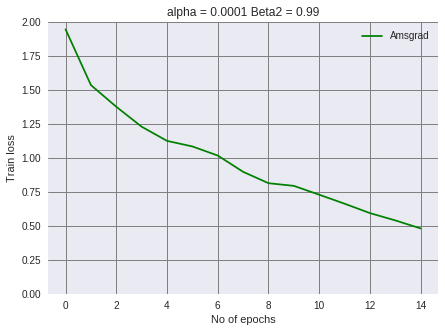

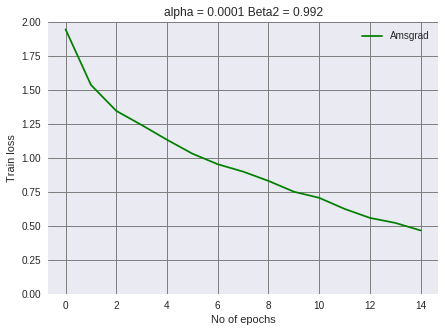

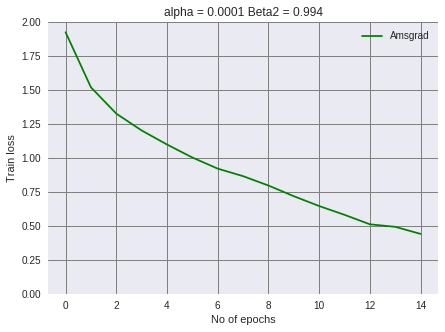

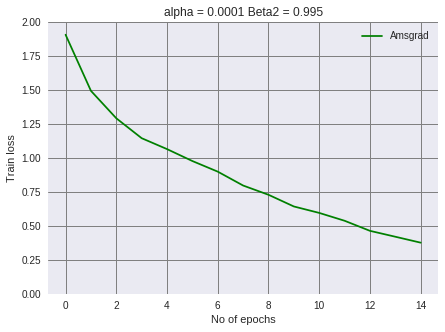

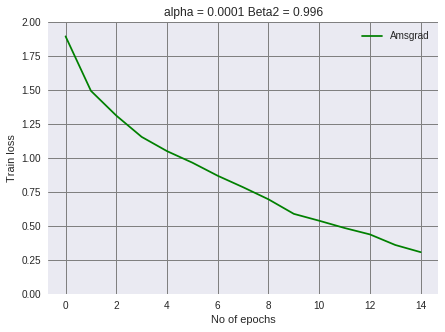

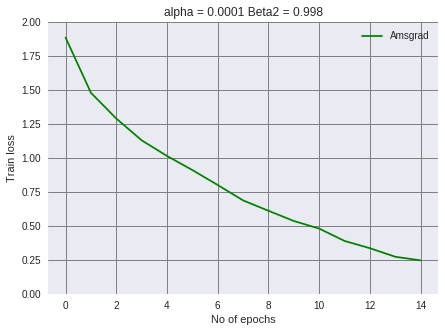

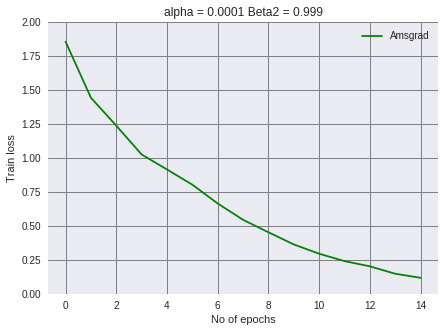

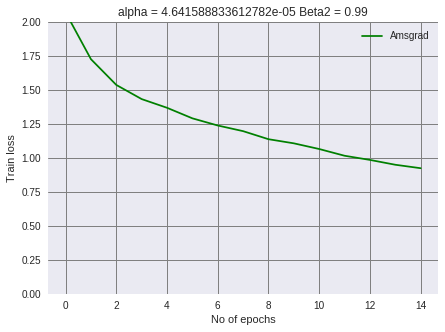

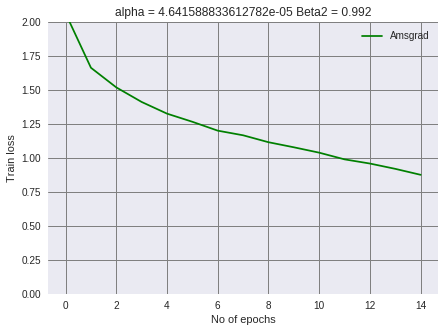

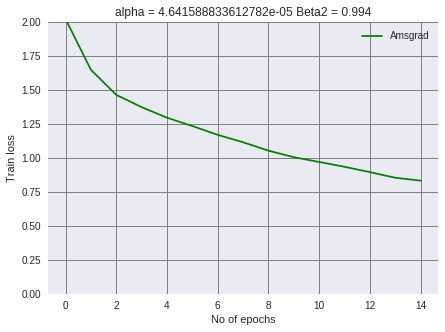

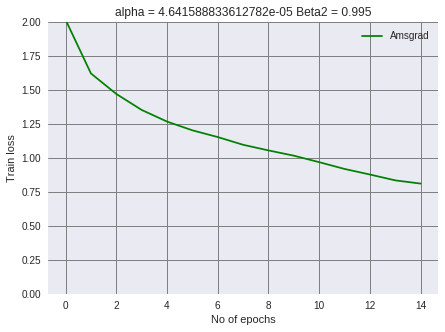

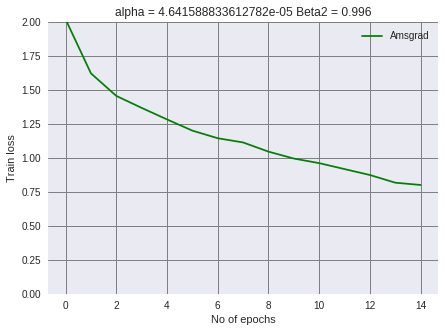

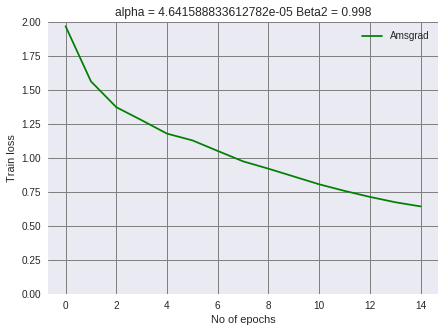

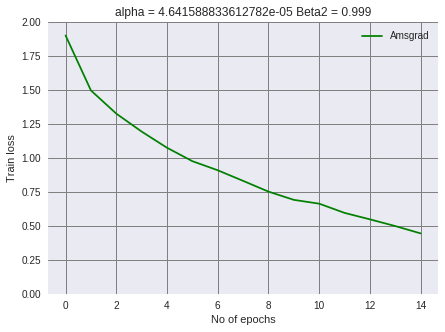

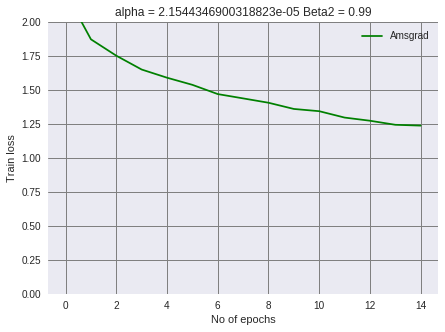

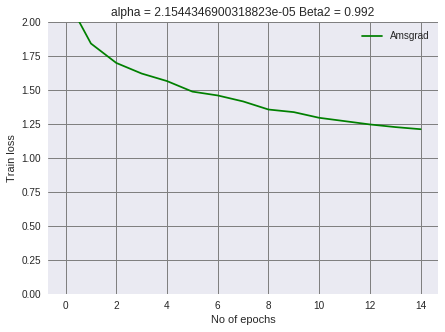

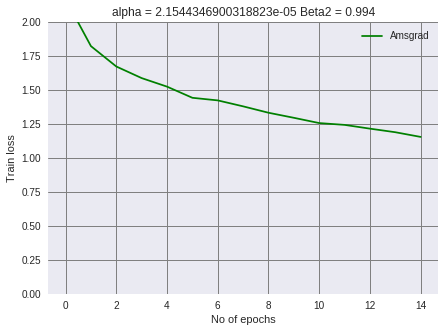

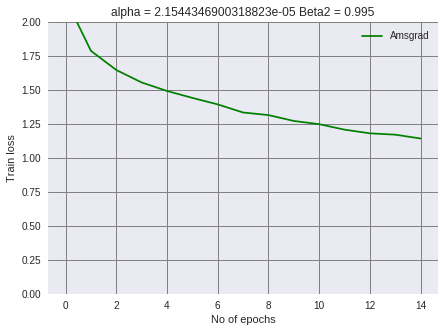

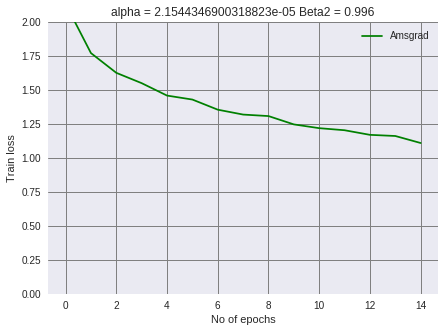

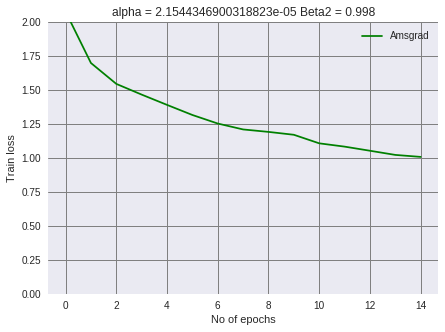

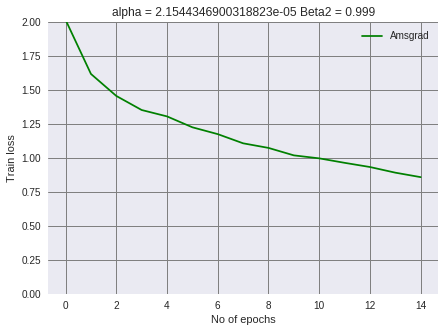

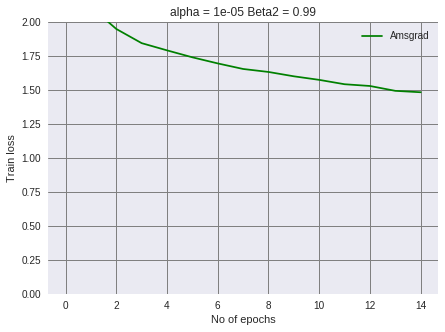

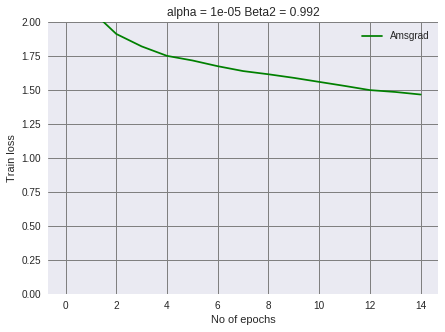

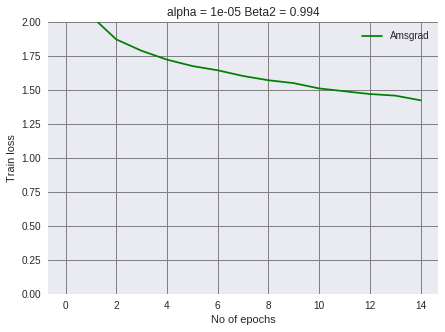

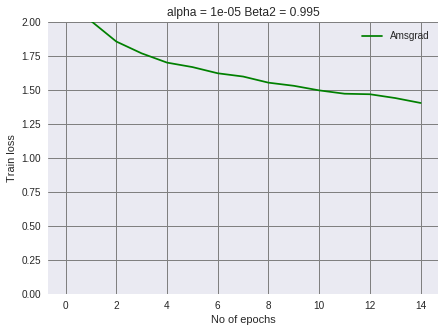

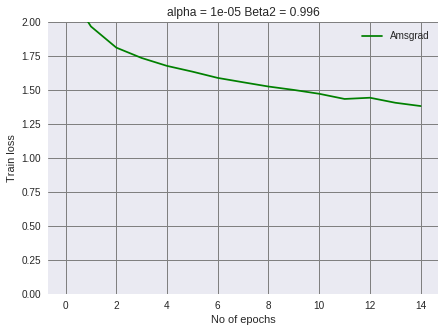

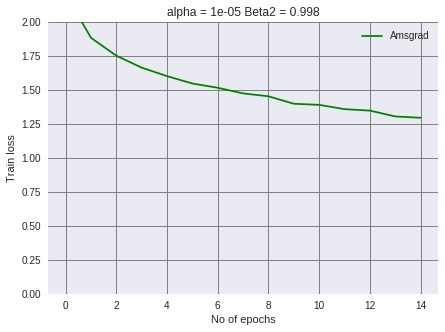

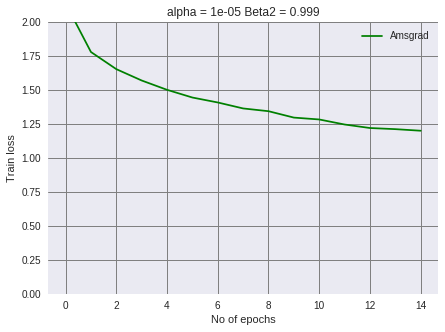

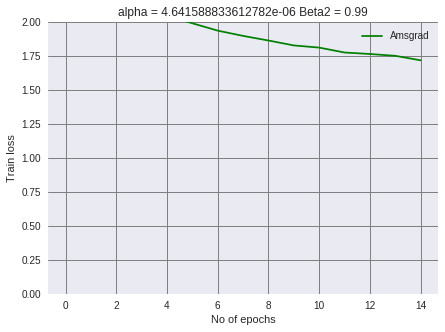

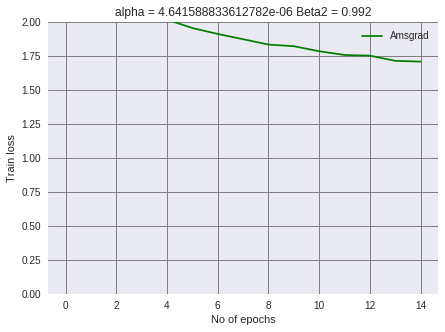

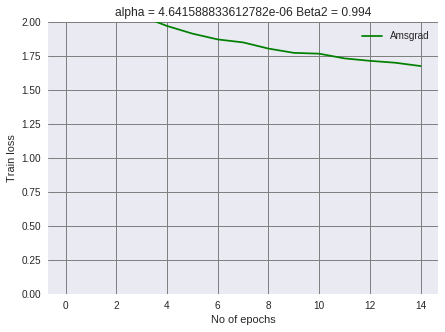

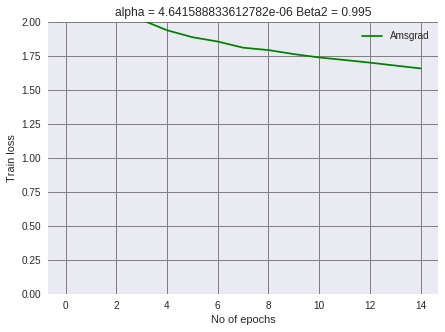

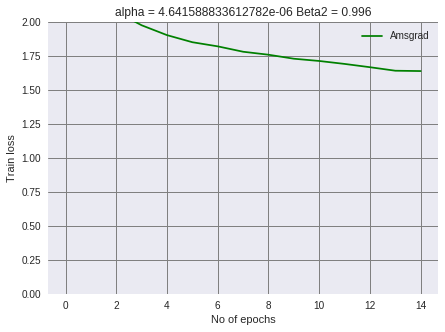

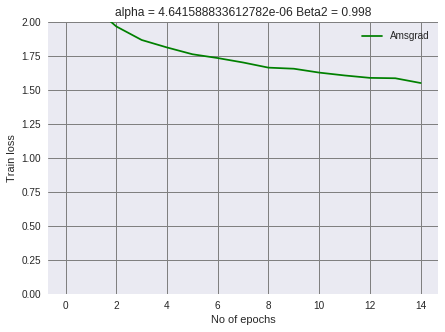

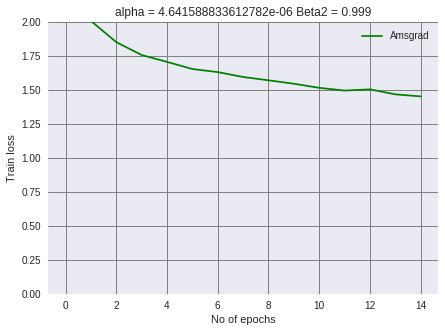

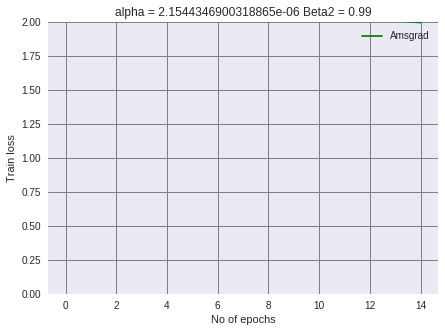

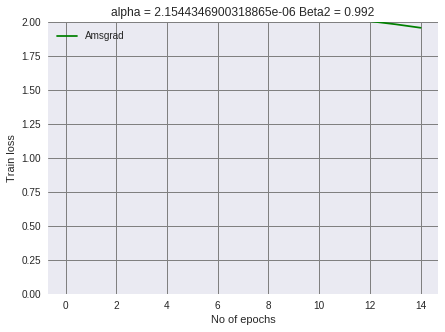

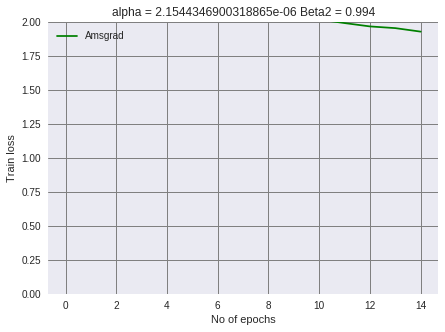

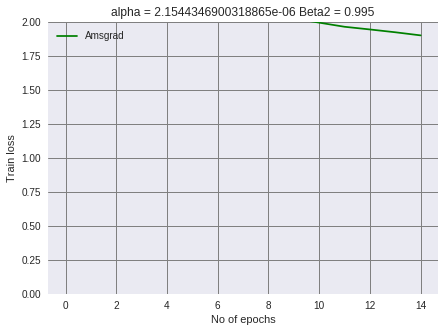

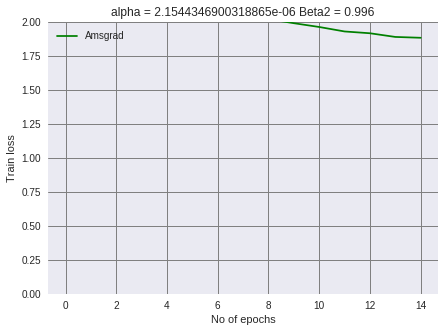

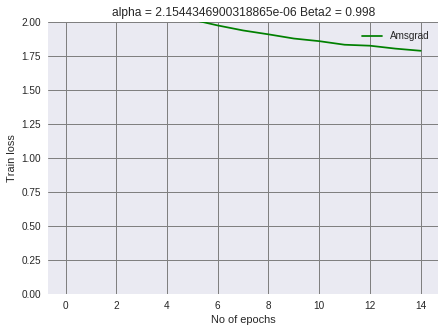

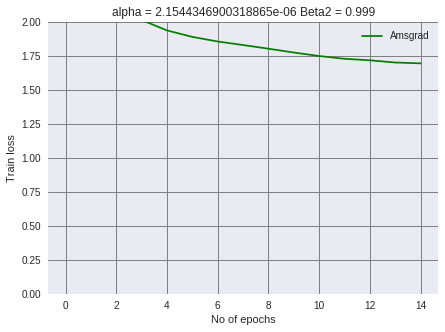

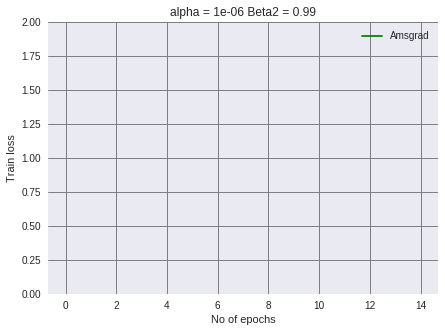

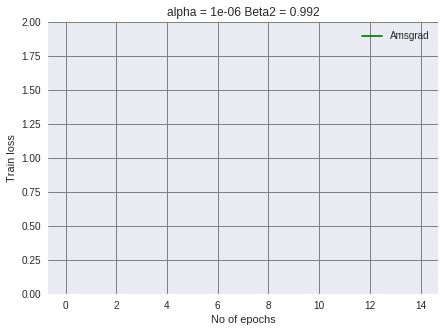

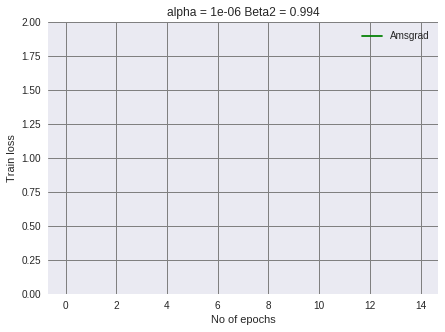

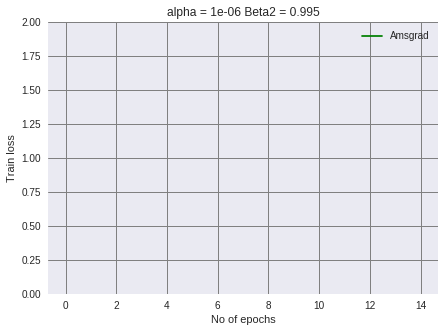

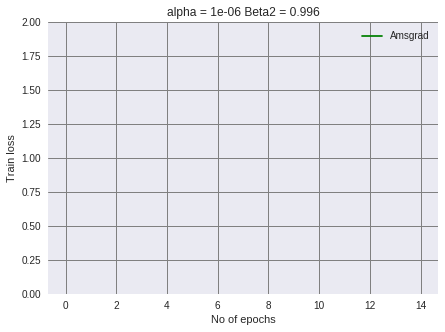

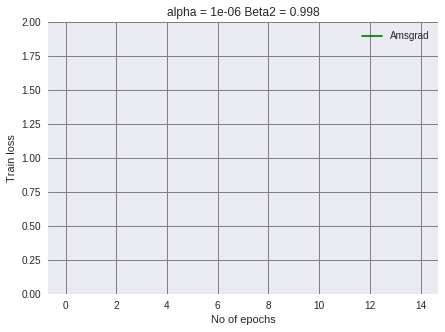

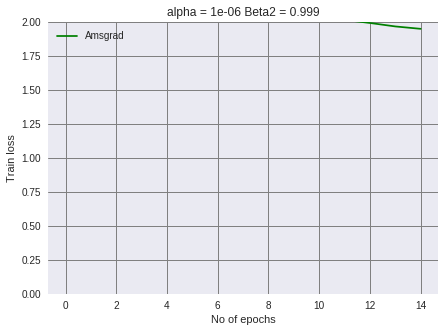

In [15]:
#Plotting train loss vs number of iterations graph for every hyper-parameter combination for AMSGrad

x = np.arange(0,num_epochs)
print(x)
for i in range(len(train_loss_list)):
  
  plt.figure(figsize=(7,5))
  title = "alpha = " + str(train_loss_list[i][1]) + " Beta2 = " + str(train_loss_list[i][2])
  plt.title(title)
  plt.plot(x, train_loss_list[i][0], 'g', label="Amsgrad")
  plt.ylim(0,2)
  plt.grid(color='gray', linewidth=1)
  plt.legend(loc='best')
  plt.xlabel('No of epochs')
  plt.ylabel('Train loss')
  plt.show()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


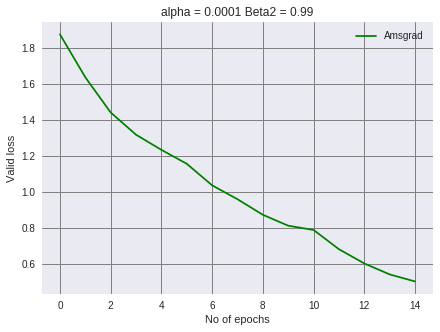

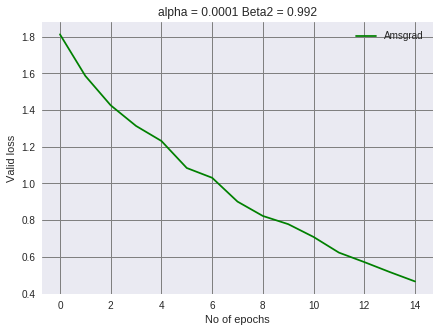

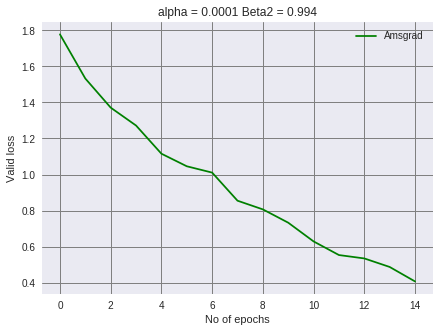

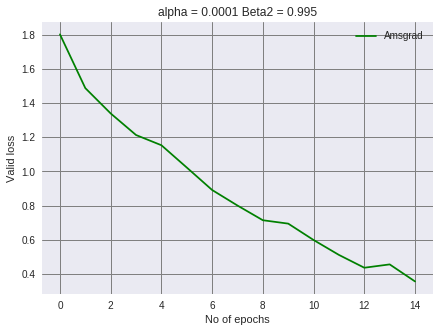

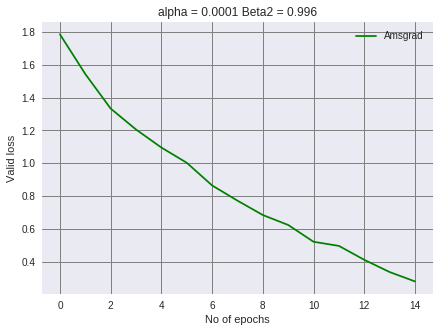

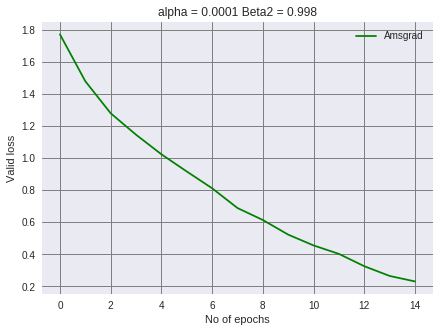

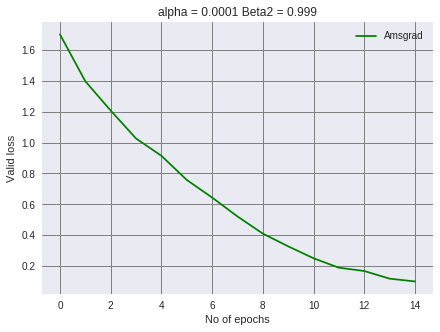

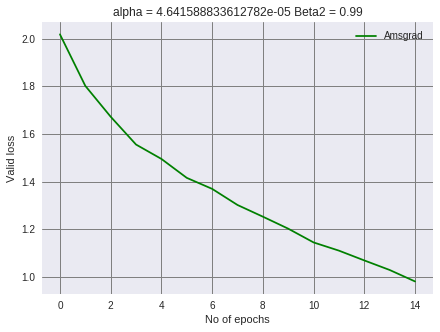

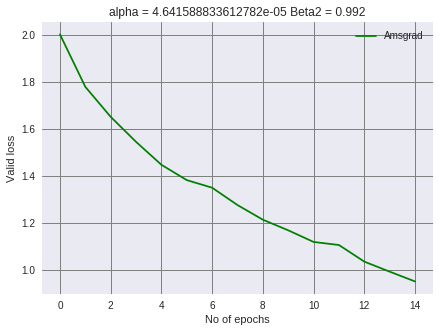

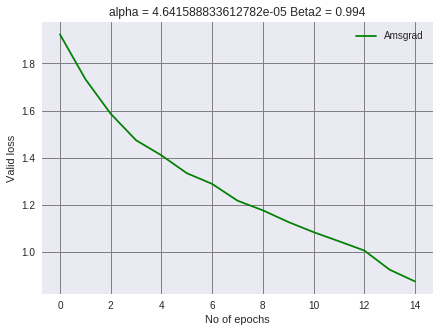

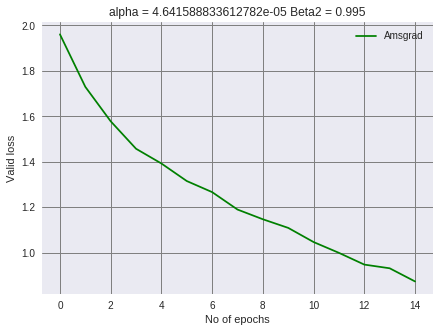

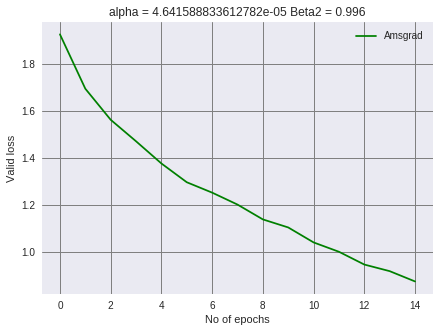

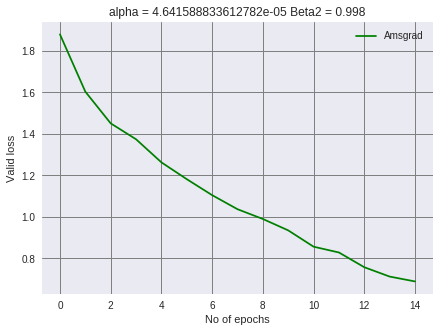

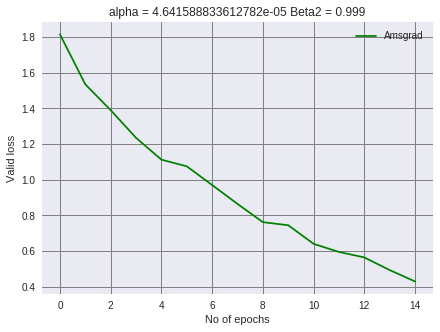

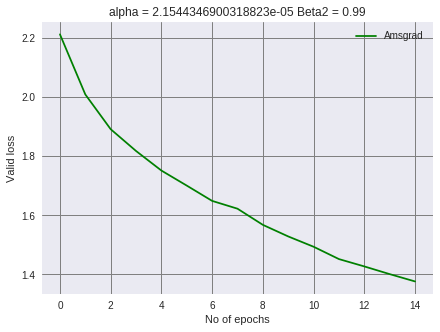

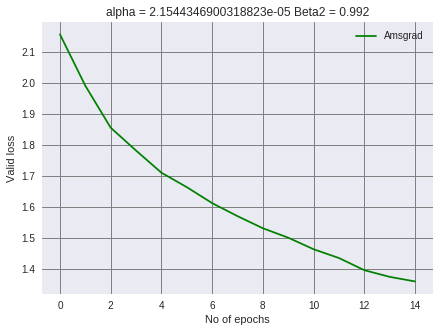

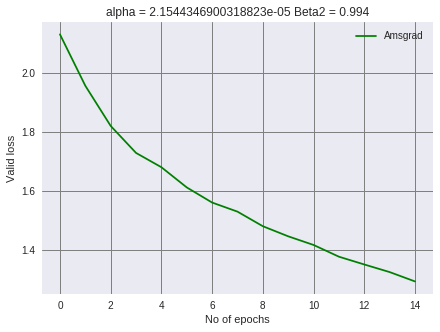

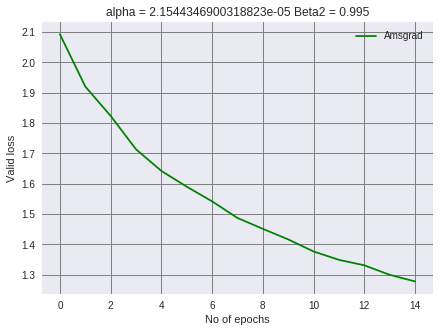

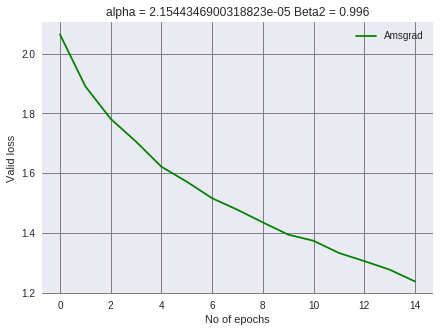

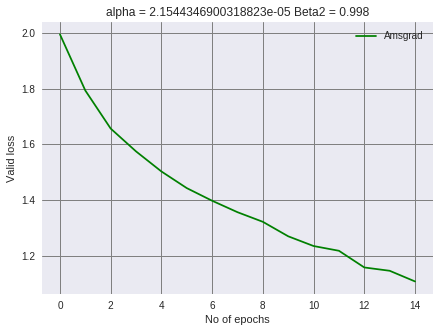

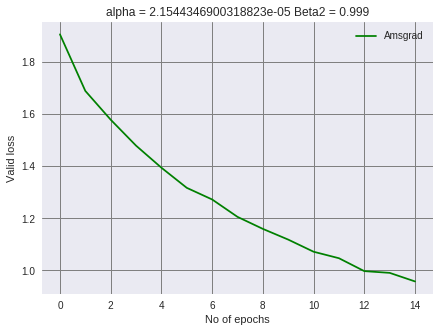

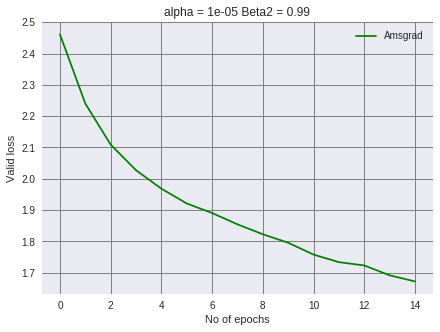

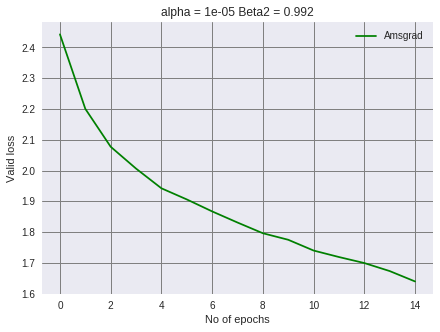

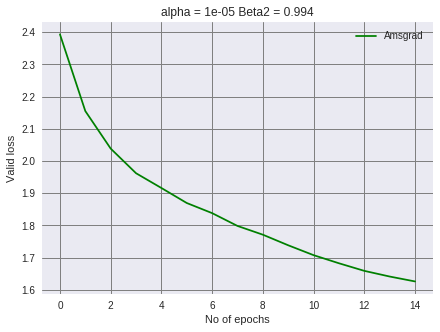

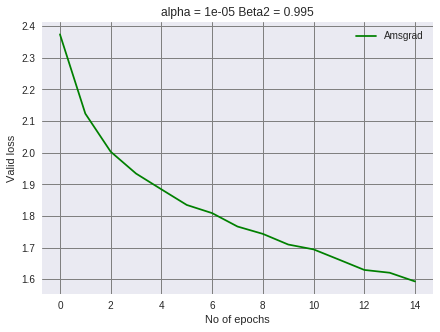

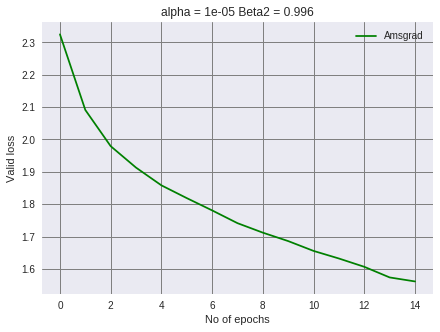

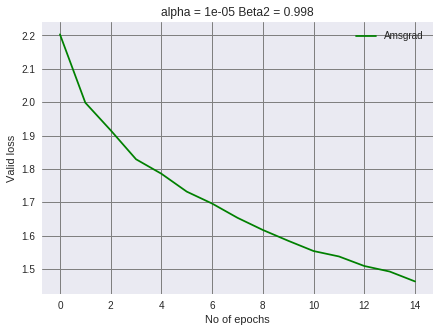

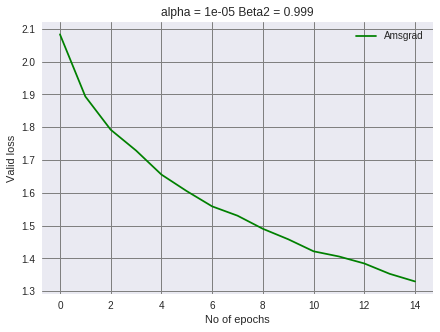

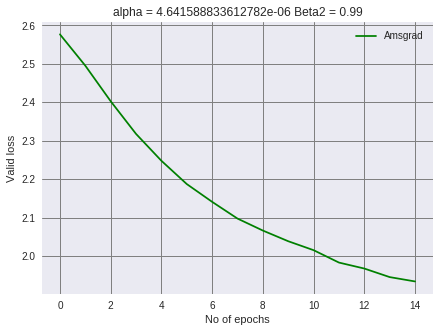

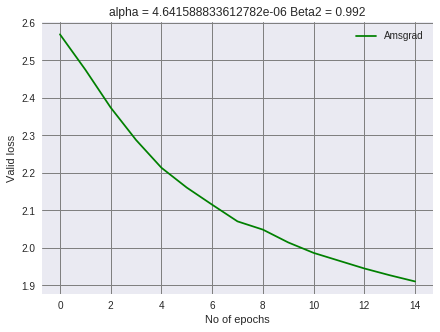

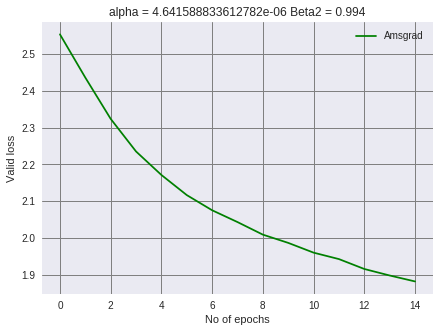

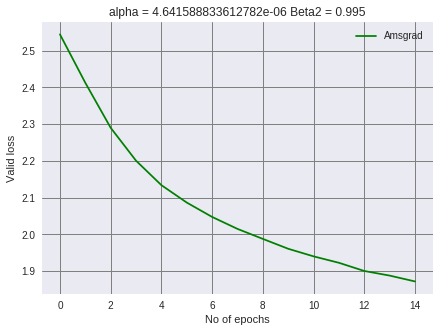

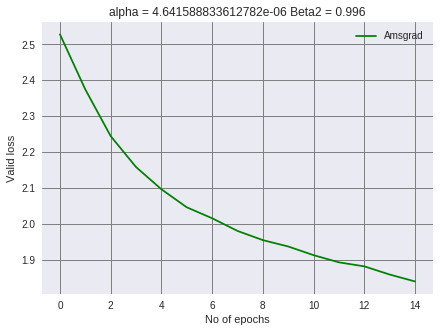

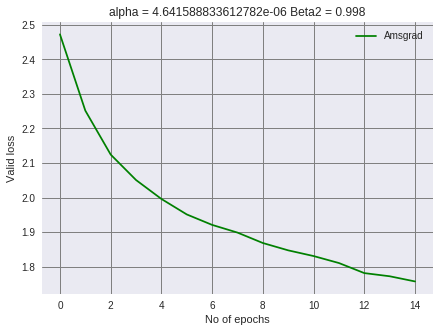

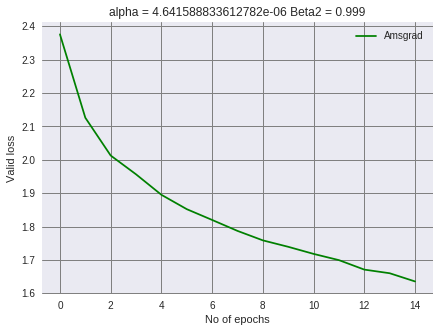

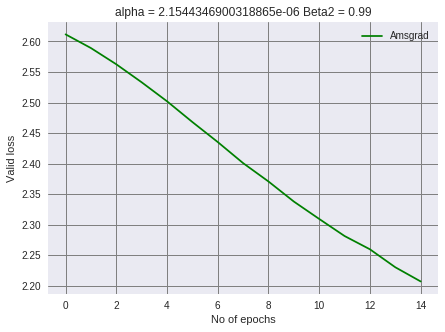

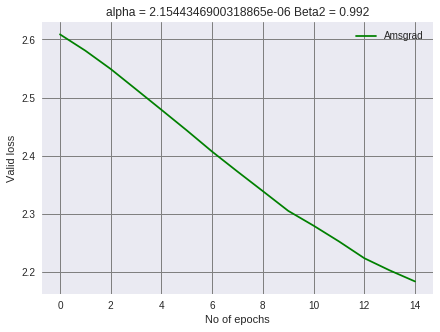

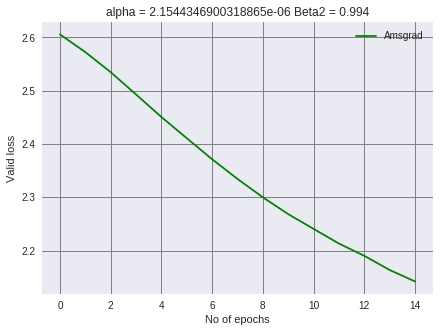

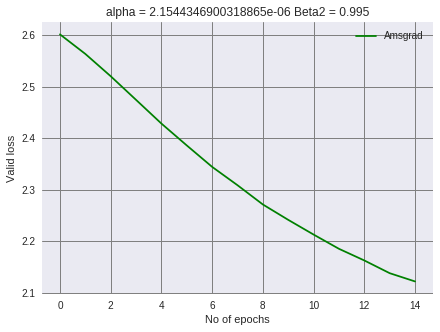

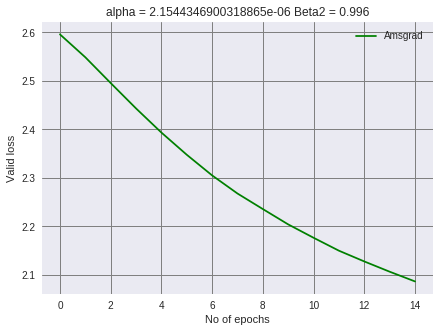

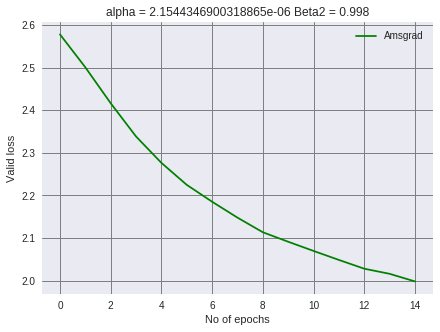

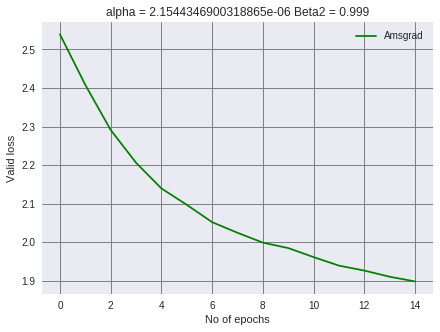

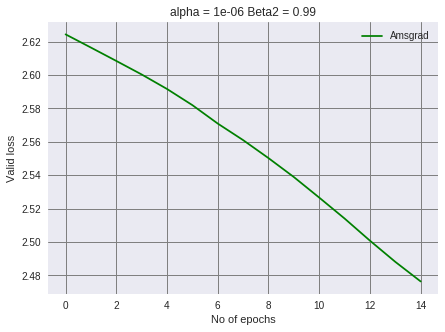

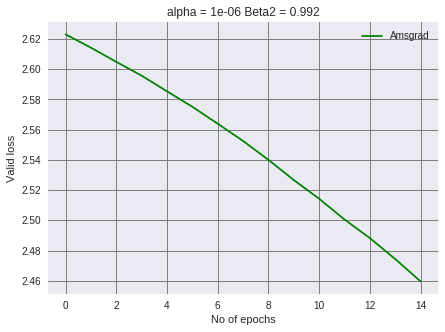

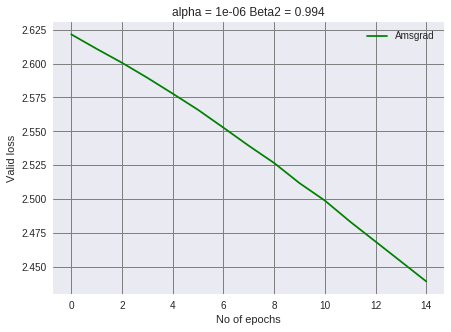

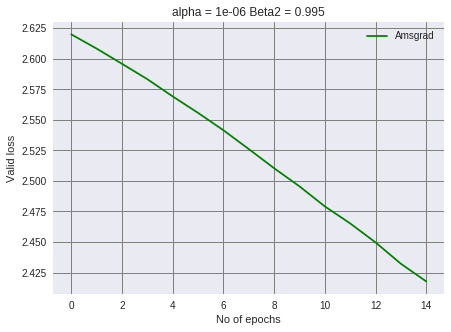

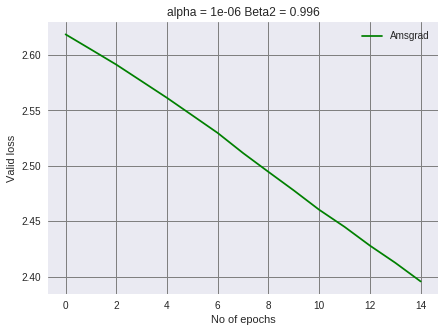

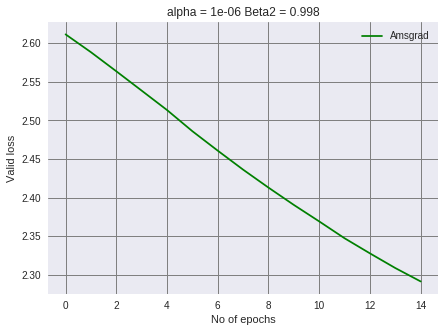

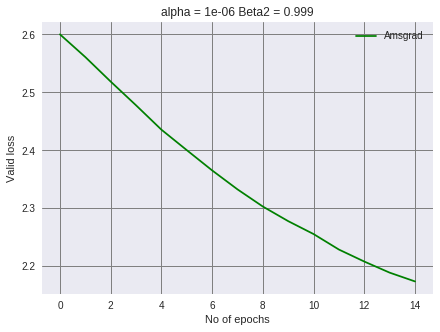

In [16]:
#Plotting validation loss vs number of iterations graph for every hyper-parameter combination for AMSGrad

x = np.arange(0,num_epochs)
print(x)
for i in range(len(valid_loss_list)):
  
  plt.figure(figsize=(7,5))
  title = "alpha = " + str(valid_loss_list[i][1]) + " Beta2 = " + str(valid_loss_list[i][2])
  plt.title(title)
  plt.plot(x, valid_loss_list[i][0], 'g', label="Amsgrad")
  plt.grid(color='gray', linewidth=1)
  plt.legend(loc='best')
  plt.xlabel('No of epochs')
  plt.ylabel('Valid loss')
  plt.show()

In [0]:
#Minimum validation loss was calculated for eachcombination  and  the  pair  which  resulted  in  least  validationloss with a non-increasing trajectory of validation loss withepochs was chosen as the best value for the hyper-parameters

min_valid_loss = []
param_combo_count = 0   
for alpha_idx, alpha in enumerate(alphas):
  for beta_idx, beta in enumerate(betas):
    min_valid_for_alpha_beta = (min(valid_loss_list[param_combo_count][0]))
    min_valid_loss.append(min_valid_for_alpha_beta)
    param_combo_count += 1

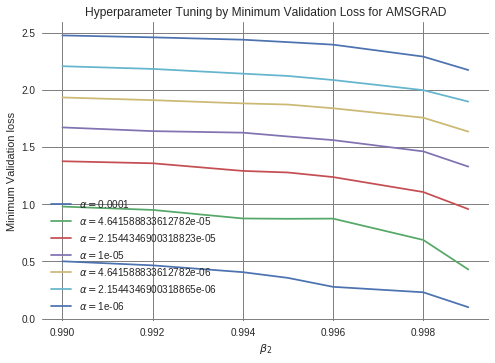

In [18]:
# Hyperparameter Tuning results by Minimum Validation Loss for AMSGRAD

count = 0
title = "Hyperparameter Tuning by Minimum Validation Loss for AMSGRAD"
plt.title(title)
for i , alpha in enumerate(alphas):
  plt.plot(betas, min_valid_loss[count:count+len(betas)], label=r'$\alpha = $'+str(alpha))
  count += len(betas)
plt.gca().set_facecolor('w')
plt.grid(color='gray', linewidth=1)
plt.legend(loc='best')
#plt.ylim(0,2.7)
plt.xlabel(r'$\beta_2$')
plt.ylabel('Minimum Validation loss')
plt.show()

In [0]:
alpha_amsgrad = 2.15443469e-05
beta2_amsgrad = 0.999

In [0]:
# Instanstiating the network on GPU

net.load_state_dict(initial_state)

In [0]:
# Learning the parameters using Amsgrad optimization with categorical cross-entropy loss. The learning rate is initially set to 0.001.
optimizer = Amsgrad(net.parameters(), lr=alpha_amsgrad, betas=(0.9,beta2_amsgrad))

In [32]:
#The code below runs for 70 epochs, learns the parameters of the model using Amsgrad optimizer with cross-entropy loss function 
#and propagates back the gradients in the network. It prints the train loss after every epoch and validation loss after each epoch.
train_loss_list_epoch = []
test_loss_list_epoch = []
train_loss_list_iter = []
pkl_filename = 'nn_saved_model.pkl'
num_epochs = 70
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss_train = 0.0
    
    for i, data in enumerate(trainloader_cifar_10, 0):
        running_loss = 0.0
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss_train += loss.data[0]
        running_loss = loss.data[0]
        train_loss_list_iter.append(running_loss)
    train_loss = running_loss_train/num_batches_train
    test_loss = validation_loss(testloader_cifar_10, num_batches_test, net, criterion)
    print ('Epoch: %d Train loss: %.3f' %(epoch + 1, train_loss))
    print ('Epoch: %d Test loss: %.3f' %(epoch + 1, test_loss))
    train_loss_list_epoch.append(train_loss)
    test_loss_list_epoch.append(test_loss)

    torch.save(net.state_dict(), pkl_filename)

print('Finished Training')

Epoch: 1 Train loss: 1.440
Epoch: 1 Test loss: 1.252
Epoch: 2 Train loss: 1.153
Epoch: 2 Test loss: 1.126
Epoch: 3 Train loss: 1.043
Epoch: 3 Test loss: 1.054
Epoch: 4 Train loss: 0.971
Epoch: 4 Test loss: 1.008
Epoch: 5 Train loss: 0.917
Epoch: 5 Test loss: 0.979
Epoch: 6 Train loss: 0.876
Epoch: 6 Test loss: 0.960
Epoch: 7 Train loss: 0.839
Epoch: 7 Test loss: 0.941
Epoch: 8 Train loss: 0.809
Epoch: 8 Test loss: 0.930
Epoch: 9 Train loss: 0.779
Epoch: 9 Test loss: 0.905
Epoch: 10 Train loss: 0.751
Epoch: 10 Test loss: 0.889
Epoch: 11 Train loss: 0.726
Epoch: 11 Test loss: 0.884
Epoch: 12 Train loss: 0.705
Epoch: 12 Test loss: 0.880
Epoch: 13 Train loss: 0.682
Epoch: 13 Test loss: 0.872
Epoch: 14 Train loss: 0.659
Epoch: 14 Test loss: 0.859
Epoch: 15 Train loss: 0.637
Epoch: 15 Test loss: 0.861
Epoch: 16 Train loss: 0.619
Epoch: 16 Test loss: 0.868
Epoch: 17 Train loss: 0.599
Epoch: 17 Test loss: 0.855
Epoch: 18 Train loss: 0.577
Epoch: 18 Test loss: 0.845
Epoch: 19 Train loss: 0.558


In [0]:
# Instanstiating the network on GPU
net_adam = CifarNet()
net_adam.load_state_dict(initial_state)
net_adam = net_adam.cuda()

In [20]:
#Hyper-parameter tuning for Adam for alpha and beta2 using trainig set of 5000 examples and validation set of 1000 examples for 15 epochs for a total of 49 hyper-parameter combinations

train_loss_list_adam = []
valid_loss_list_adam = []
for alpha in alphas:
  for beta in betas:
    train_loss_list_adam.append(([], alpha, beta))
    valid_loss_list_adam.append(([], alpha, beta))

num_epochs = 15
total_combo = len(alphas)*len(betas)

param_combo_count = 0
for alpha in alphas:
  for beta in betas:
    print("alpha:", alpha, " beta 2: ", beta)
    print("Parameter Combination:", param_combo_count+1, "/", total_combo)
    net_adam.load_state_dict(initial_state)
    optimizer_adam = optim.Adam(net_adam.parameters(), lr=alpha, betas=(0.9,beta))
    start_time_combo = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss_train = 0.0
        for i, data in enumerate(trainloader_cifar_hyp, 0):
            # get the inputs
            inputs, labels = data

            # wrap them in Variable
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

            # zero the parameter gradients
            optimizer_adam.zero_grad()

            # forward + backward + optimize
            outputs = net_adam(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer_adam.step()
            
            # print statistics
            running_loss_train += loss.data[0]
        
        train_loss = running_loss_train/num_batches_train_hyp
        valid_loss = validation_loss(validloader_cifar_hyp, num_batches_valid_hyp,net_adam, criterion)
        print ('Epoch: %d Train loss: %.3f' %(epoch + 1, train_loss))
        print ('Epoch: %d Valid loss: %.3f' %(epoch + 1, valid_loss))
        train_loss_list_adam[param_combo_count][0].append(train_loss)
        valid_loss_list_adam[param_combo_count][0].append(valid_loss)

    elapsed_time = time.time() - start_time_combo
    print('Finished Training') 
    print("Time for 1 combination of hyper-parameters: ", elapsed_time)
    param_combo_count += 1


alpha: 0.0001  beta 2:  0.99
Parameter Combination: 1 / 49
Epoch: 1 Train loss: 2.052
Epoch: 1 Valid loss: 1.989
Epoch: 2 Train loss: 1.677
Epoch: 2 Valid loss: 1.747
Epoch: 3 Train loss: 1.502
Epoch: 3 Valid loss: 1.590
Epoch: 4 Train loss: 1.361
Epoch: 4 Valid loss: 1.448
Epoch: 5 Train loss: 1.278
Epoch: 5 Valid loss: 1.340
Epoch: 6 Train loss: 1.171
Epoch: 6 Valid loss: 1.216
Epoch: 7 Train loss: 1.070
Epoch: 7 Valid loss: 1.151
Epoch: 8 Train loss: 0.995
Epoch: 8 Valid loss: 1.053
Epoch: 9 Train loss: 0.946
Epoch: 9 Valid loss: 1.005
Epoch: 10 Train loss: 0.882
Epoch: 10 Valid loss: 0.876
Epoch: 11 Train loss: 0.789
Epoch: 11 Valid loss: 0.862
Epoch: 12 Train loss: 0.748
Epoch: 12 Valid loss: 0.747
Epoch: 13 Train loss: 0.681
Epoch: 13 Valid loss: 0.709
Epoch: 14 Train loss: 0.607
Epoch: 14 Valid loss: 0.614
Epoch: 15 Train loss: 0.553
Epoch: 15 Valid loss: 0.573
Finished Training
Time for 1 combination of hyper-parameters:  43.902289390563965
alpha: 0.0001  beta 2:  0.992
Paramet

Epoch: 15 Train loss: 0.934
Epoch: 15 Valid loss: 1.029
Finished Training
Time for 1 combination of hyper-parameters:  43.530930042266846
alpha: 4.641588833612782e-05  beta 2:  0.996
Parameter Combination: 12 / 49
Epoch: 1 Train loss: 2.191
Epoch: 1 Valid loss: 2.155
Epoch: 2 Train loss: 1.816
Epoch: 2 Valid loss: 1.922
Epoch: 3 Train loss: 1.642
Epoch: 3 Valid loss: 1.782
Epoch: 4 Train loss: 1.527
Epoch: 4 Valid loss: 1.662
Epoch: 5 Train loss: 1.431
Epoch: 5 Valid loss: 1.565
Epoch: 6 Train loss: 1.362
Epoch: 6 Valid loss: 1.503
Epoch: 7 Train loss: 1.316
Epoch: 7 Valid loss: 1.409
Epoch: 8 Train loss: 1.224
Epoch: 8 Valid loss: 1.359
Epoch: 9 Train loss: 1.196
Epoch: 9 Valid loss: 1.287
Epoch: 10 Train loss: 1.145
Epoch: 10 Valid loss: 1.240
Epoch: 11 Train loss: 1.081
Epoch: 11 Valid loss: 1.172
Epoch: 12 Train loss: 1.043
Epoch: 12 Valid loss: 1.143
Epoch: 13 Train loss: 0.997
Epoch: 13 Valid loss: 1.084
Epoch: 14 Train loss: 0.946
Epoch: 14 Valid loss: 1.051
Epoch: 15 Train loss

Epoch: 12 Train loss: 1.572
Epoch: 12 Valid loss: 1.773
Epoch: 13 Train loss: 1.551
Epoch: 13 Valid loss: 1.745
Epoch: 14 Train loss: 1.525
Epoch: 14 Valid loss: 1.715
Epoch: 15 Train loss: 1.502
Epoch: 15 Valid loss: 1.701
Finished Training
Time for 1 combination of hyper-parameters:  43.713523149490356
alpha: 1e-05  beta 2:  0.992
Parameter Combination: 23 / 49
Epoch: 1 Train loss: 2.342
Epoch: 1 Valid loss: 2.565
Epoch: 2 Train loss: 2.253
Epoch: 2 Valid loss: 2.429
Epoch: 3 Train loss: 2.116
Epoch: 3 Valid loss: 2.272
Epoch: 4 Train loss: 1.985
Epoch: 4 Valid loss: 2.145
Epoch: 5 Train loss: 1.889
Epoch: 5 Valid loss: 2.062
Epoch: 6 Train loss: 1.814
Epoch: 6 Valid loss: 1.993
Epoch: 7 Train loss: 1.741
Epoch: 7 Valid loss: 1.944
Epoch: 8 Train loss: 1.709
Epoch: 8 Valid loss: 1.905
Epoch: 9 Train loss: 1.682
Epoch: 9 Valid loss: 1.868
Epoch: 10 Train loss: 1.632
Epoch: 10 Valid loss: 1.831
Epoch: 11 Train loss: 1.614
Epoch: 11 Valid loss: 1.796
Epoch: 12 Train loss: 1.579
Epoch: 1

Epoch: 12 Train loss: 1.800
Epoch: 12 Valid loss: 1.997
Epoch: 13 Train loss: 1.767
Epoch: 13 Valid loss: 1.976
Epoch: 14 Train loss: 1.751
Epoch: 14 Valid loss: 1.950
Epoch: 15 Train loss: 1.741
Epoch: 15 Valid loss: 1.929
Finished Training
Time for 1 combination of hyper-parameters:  43.50604438781738
alpha: 4.641588833612782e-06  beta 2:  0.998
Parameter Combination: 34 / 49
Epoch: 1 Train loss: 2.353
Epoch: 1 Valid loss: 2.608
Epoch: 2 Train loss: 2.326
Epoch: 2 Valid loss: 2.568
Epoch: 3 Train loss: 2.281
Epoch: 3 Valid loss: 2.507
Epoch: 4 Train loss: 2.218
Epoch: 4 Valid loss: 2.427
Epoch: 5 Train loss: 2.146
Epoch: 5 Valid loss: 2.341
Epoch: 6 Train loss: 2.067
Epoch: 6 Valid loss: 2.267
Epoch: 7 Train loss: 2.006
Epoch: 7 Valid loss: 2.193
Epoch: 8 Train loss: 1.941
Epoch: 8 Valid loss: 2.142
Epoch: 9 Train loss: 1.897
Epoch: 9 Valid loss: 2.094
Epoch: 10 Train loss: 1.860
Epoch: 10 Valid loss: 2.057
Epoch: 11 Train loss: 1.820
Epoch: 11 Valid loss: 2.020
Epoch: 12 Train loss:

Epoch: 12 Train loss: 2.280
Epoch: 12 Valid loss: 2.534
Epoch: 13 Train loss: 2.270
Epoch: 13 Valid loss: 2.521
Epoch: 14 Train loss: 2.258
Epoch: 14 Valid loss: 2.507
Epoch: 15 Train loss: 2.244
Epoch: 15 Valid loss: 2.494
Finished Training
Time for 1 combination of hyper-parameters:  42.877132177352905
alpha: 1e-06  beta 2:  0.994
Parameter Combination: 45 / 49
Epoch: 1 Train loss: 2.361
Epoch: 1 Valid loss: 2.629
Epoch: 2 Train loss: 2.356
Epoch: 2 Valid loss: 2.624
Epoch: 3 Train loss: 2.352
Epoch: 3 Valid loss: 2.619
Epoch: 4 Train loss: 2.347
Epoch: 4 Valid loss: 2.613
Epoch: 5 Train loss: 2.341
Epoch: 5 Valid loss: 2.606
Epoch: 6 Train loss: 2.335
Epoch: 6 Valid loss: 2.598
Epoch: 7 Train loss: 2.327
Epoch: 7 Valid loss: 2.589
Epoch: 8 Train loss: 2.320
Epoch: 8 Valid loss: 2.580
Epoch: 9 Train loss: 2.311
Epoch: 9 Valid loss: 2.569
Epoch: 10 Train loss: 2.300
Epoch: 10 Valid loss: 2.558
Epoch: 11 Train loss: 2.290
Epoch: 11 Valid loss: 2.546
Epoch: 12 Train loss: 2.280
Epoch: 1

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


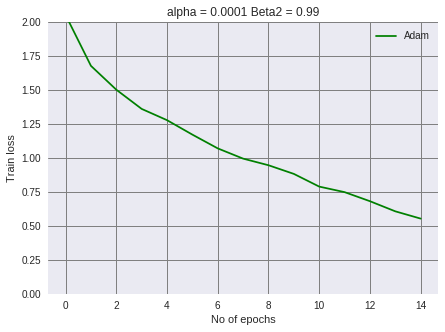

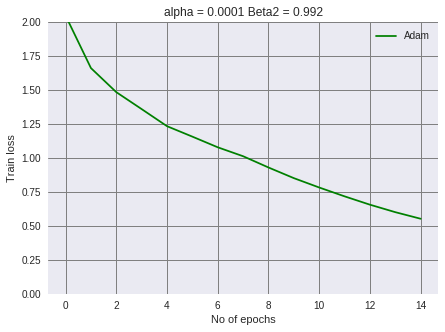

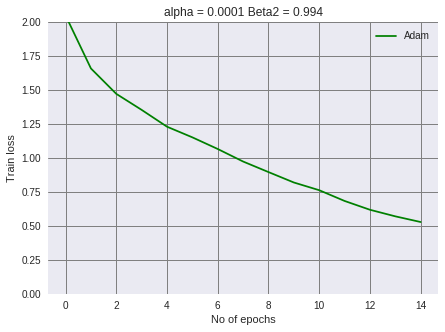

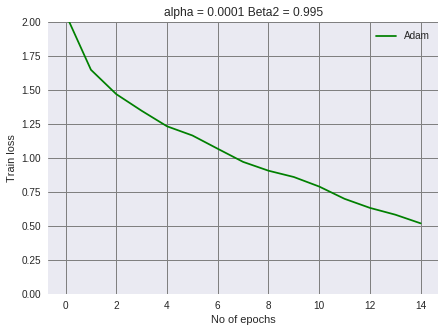

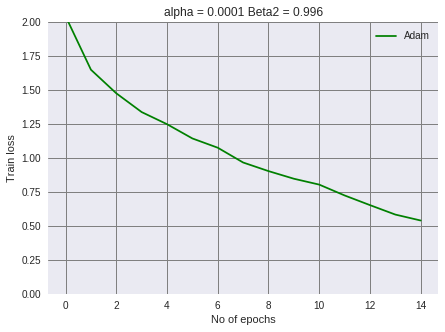

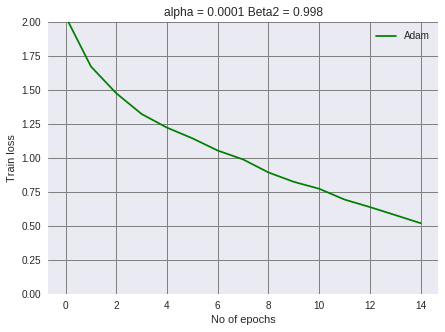

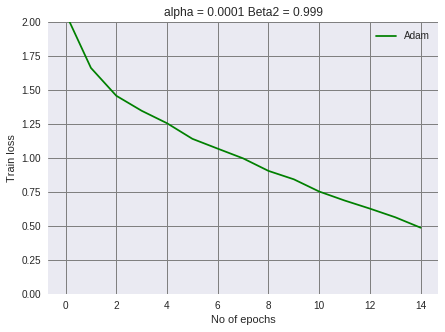

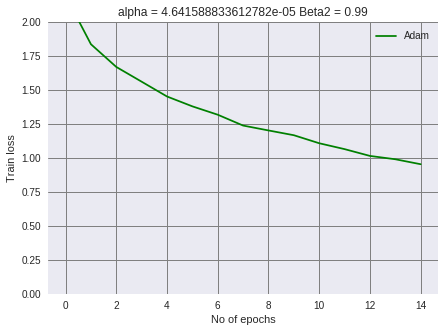

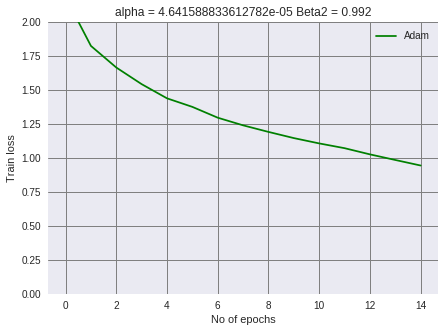

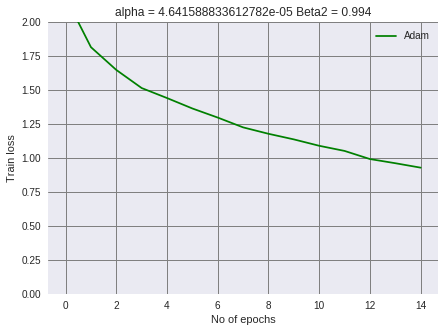

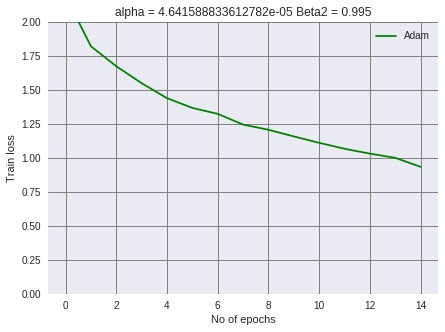

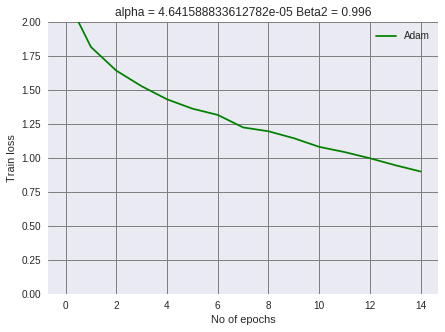

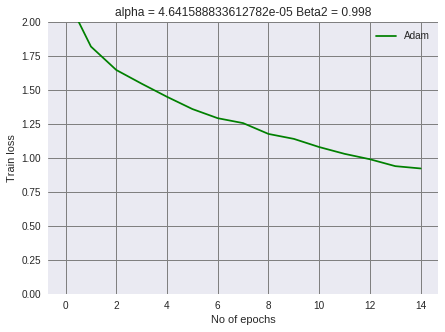

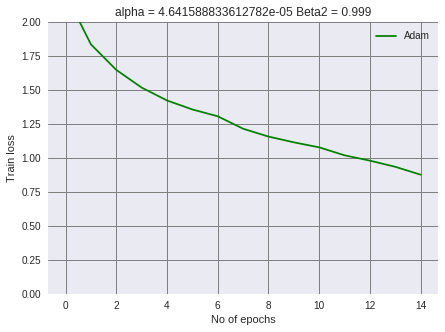

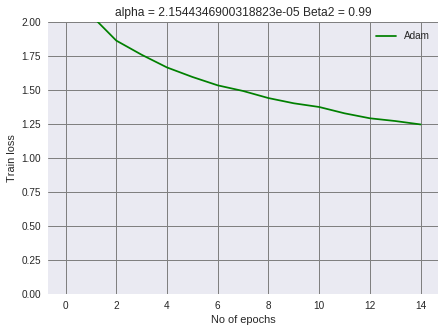

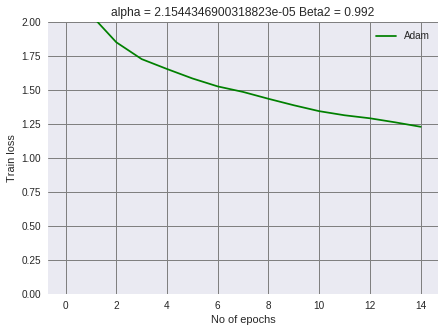

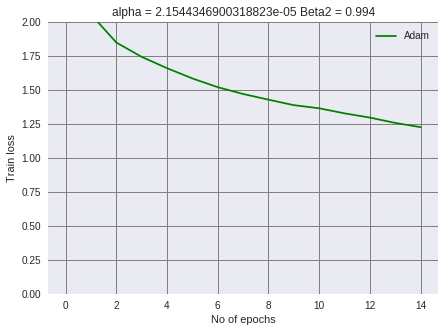

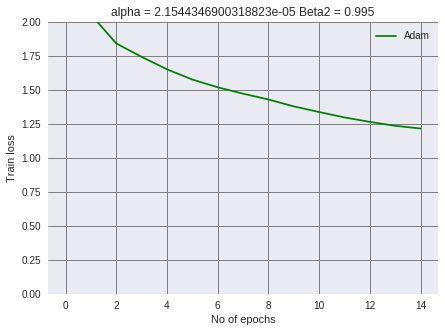

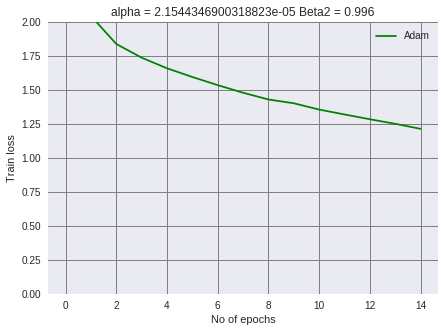

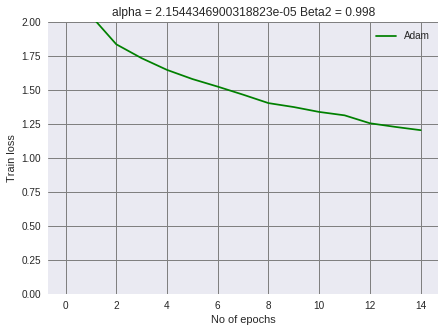

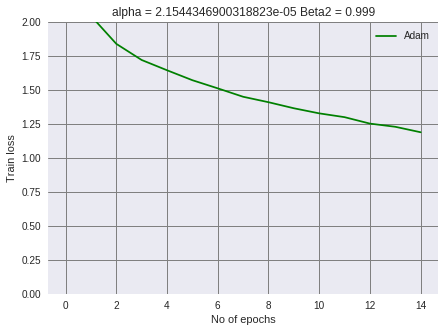

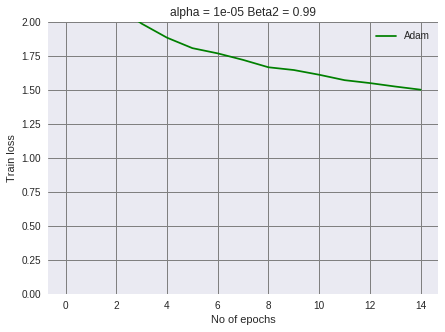

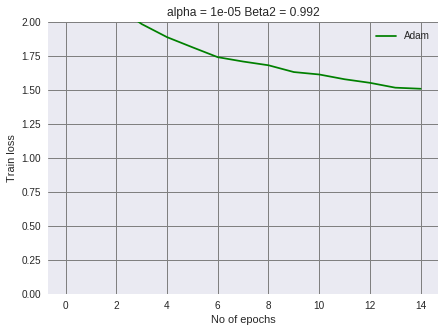

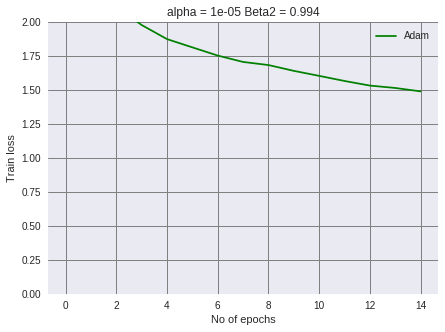

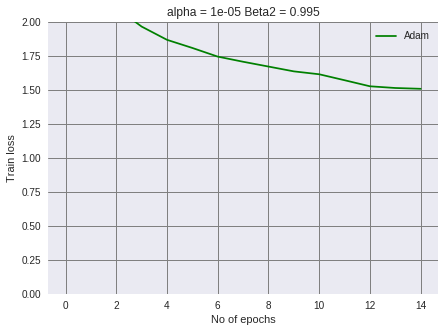

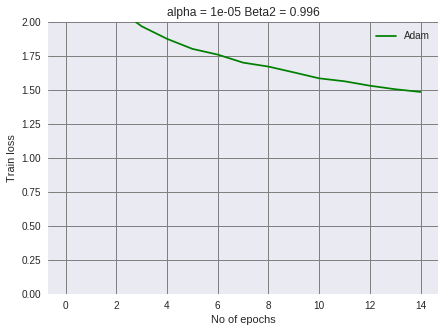

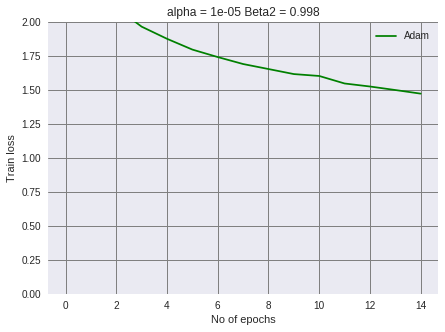

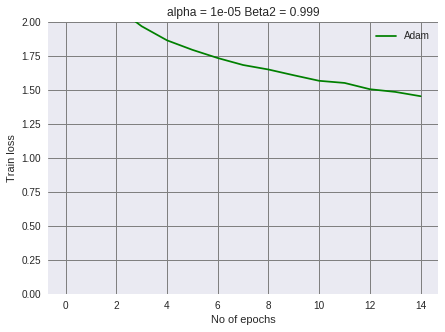

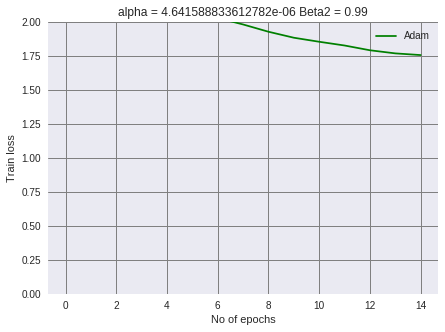

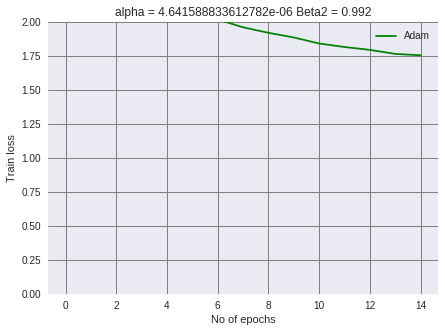

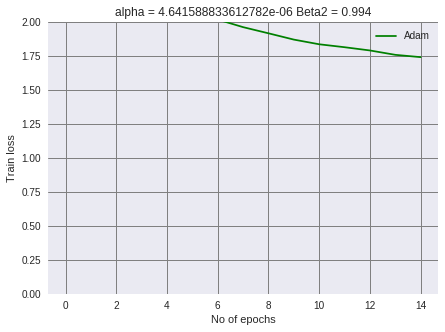

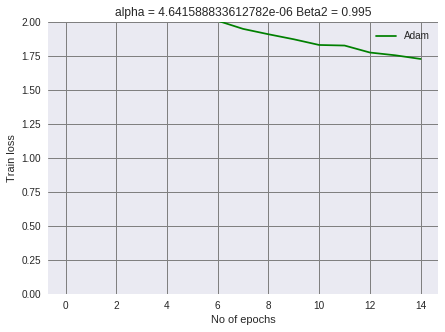

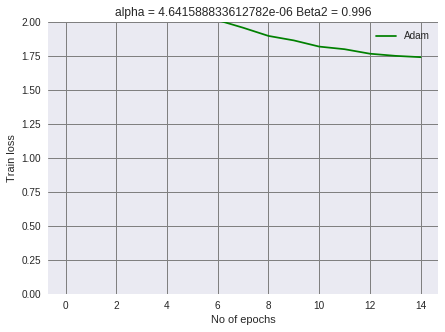

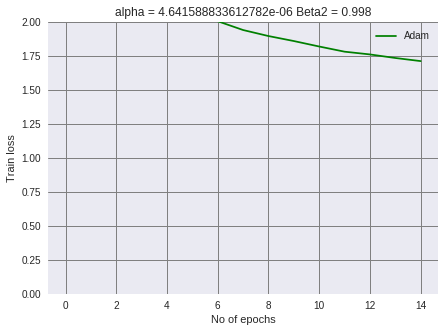

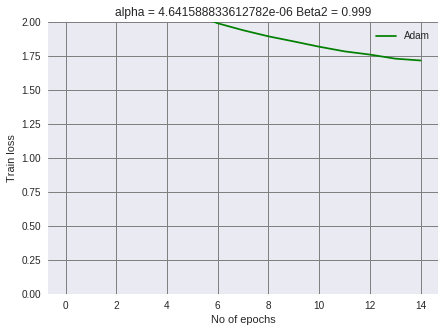

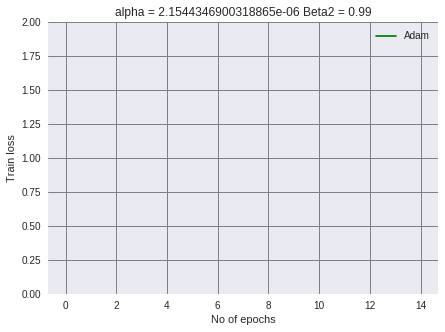

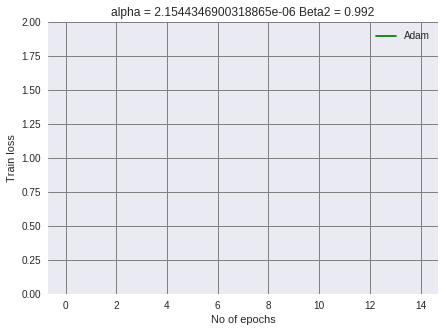

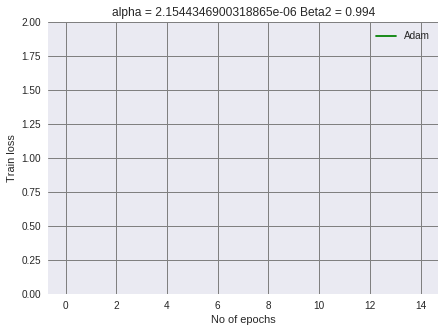

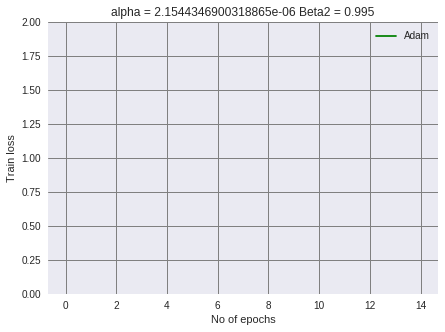

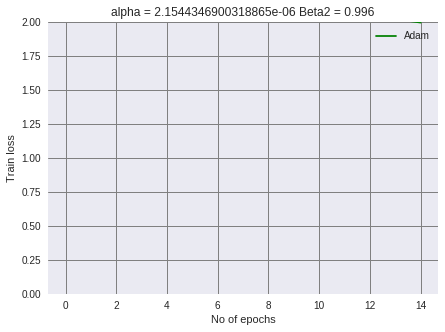

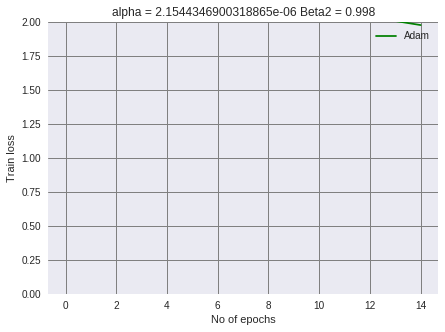

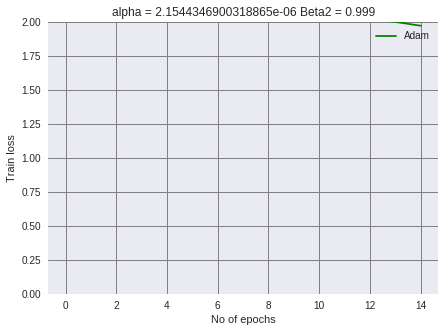

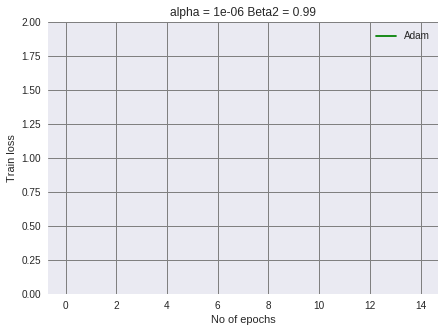

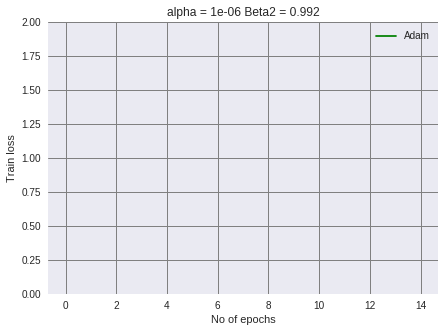

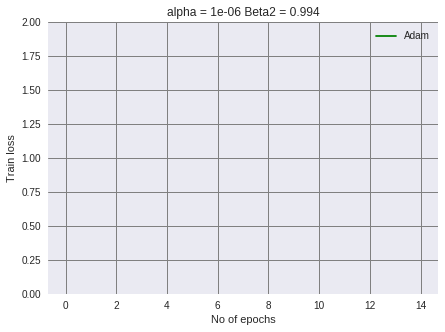

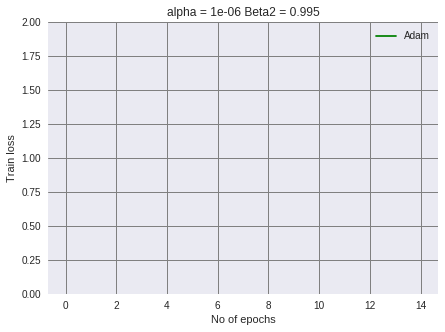

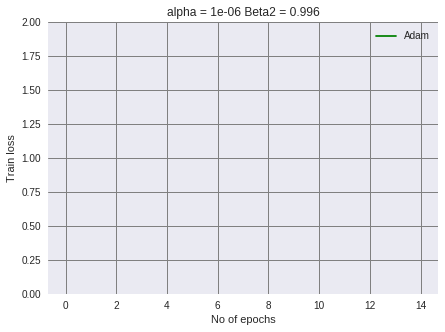

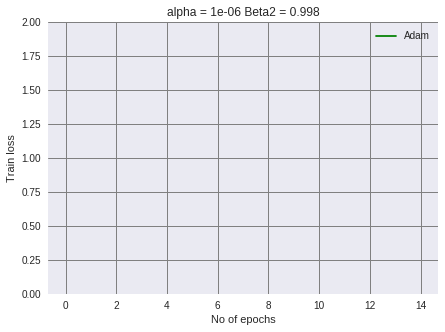

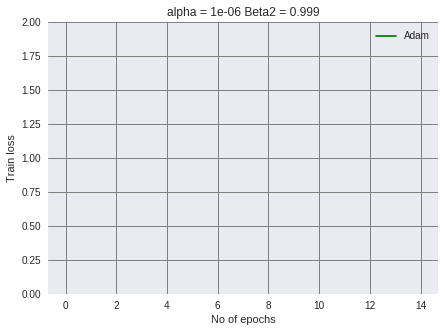

In [21]:
#Plotting train loss vs number of iterations graph for every hyper-parameter combination for Adam
x = np.arange(0,num_epochs)
print(x)
for i in range(len(train_loss_list_adam)):
  
  plt.figure(figsize=(7,5))
  title = "alpha = " + str(train_loss_list_adam[i][1]) + " Beta2 = " + str(train_loss_list_adam[i][2])
  plt.title(title)
  plt.plot(x, train_loss_list_adam[i][0], 'g', label="Adam")
  plt.ylim(0,2)
  plt.grid(color='gray', linewidth=1)
  plt.legend(loc='best')
  plt.xlabel('No of epochs')
  plt.ylabel('Train loss')
  plt.show()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


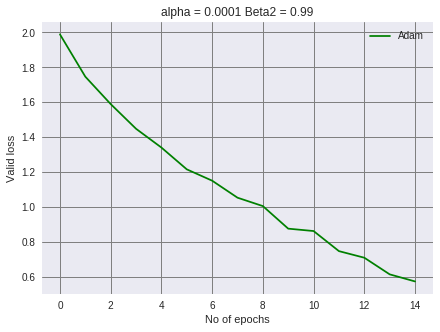

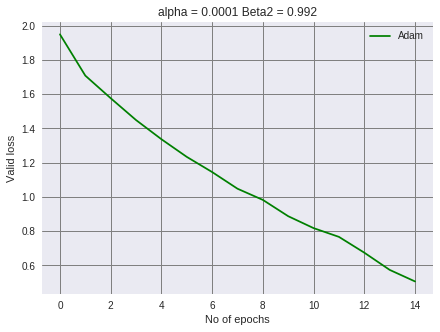

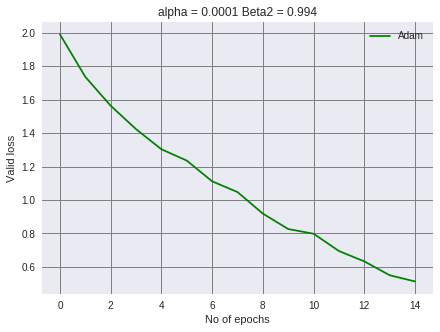

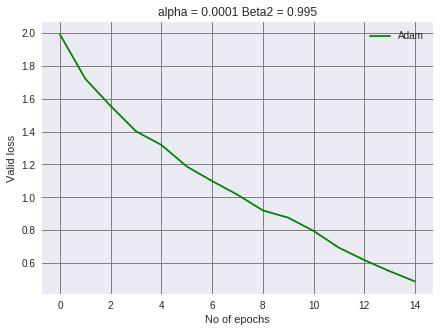

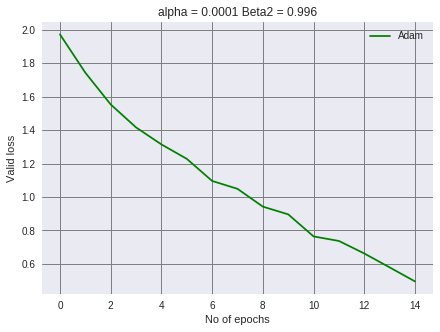

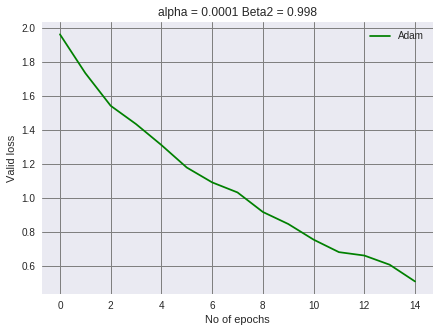

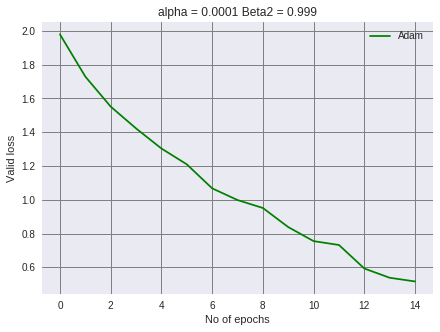

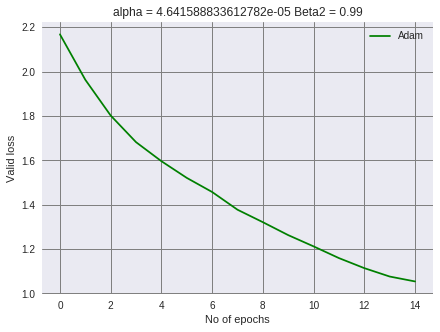

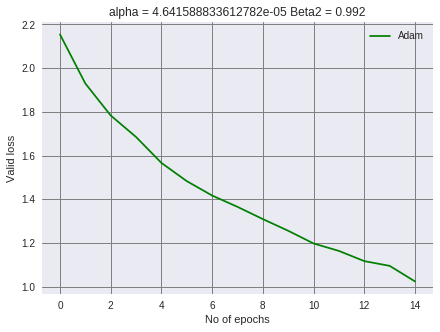

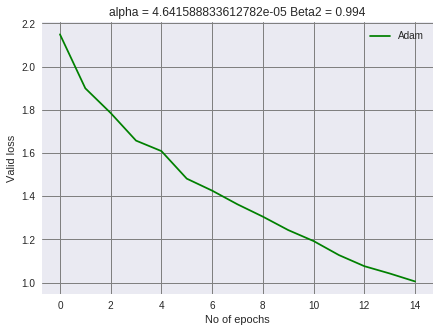

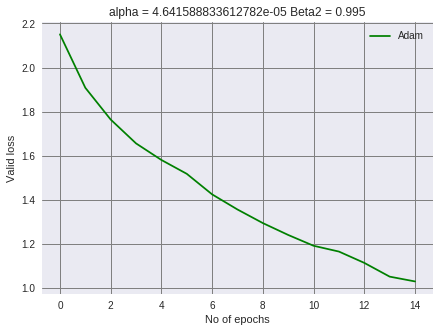

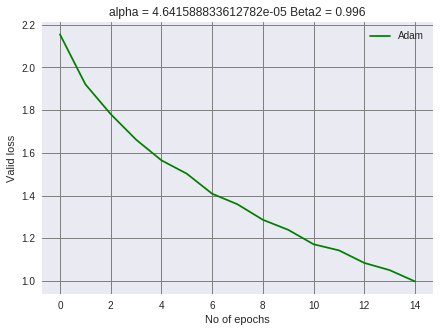

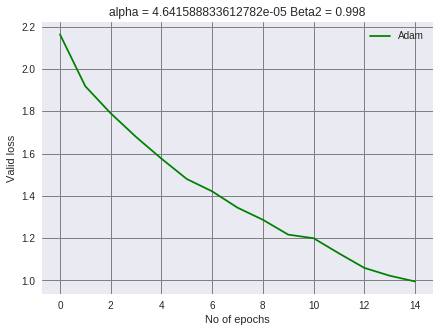

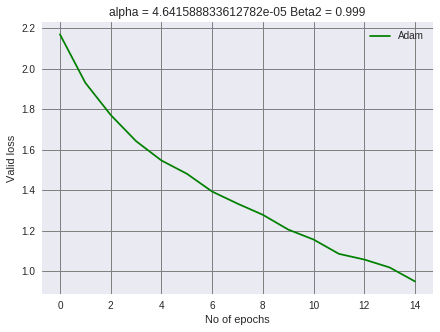

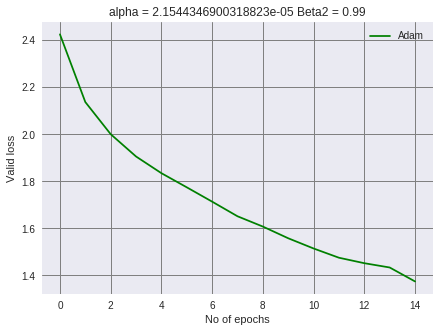

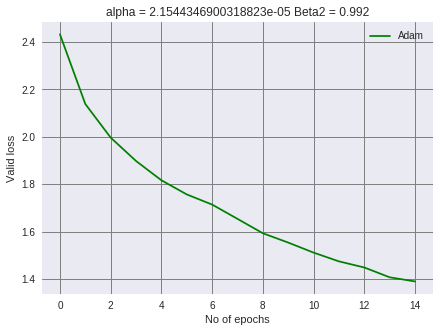

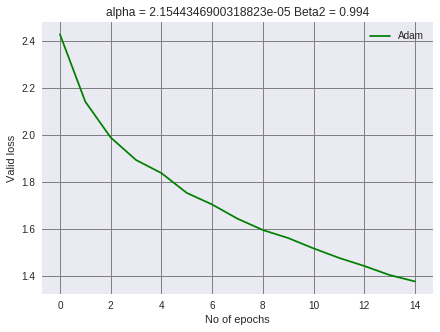

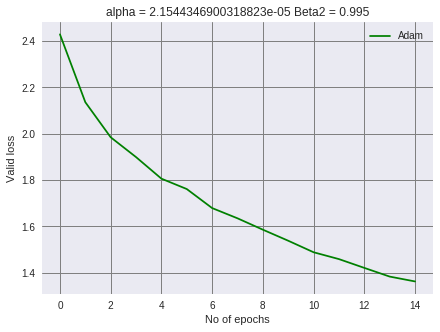

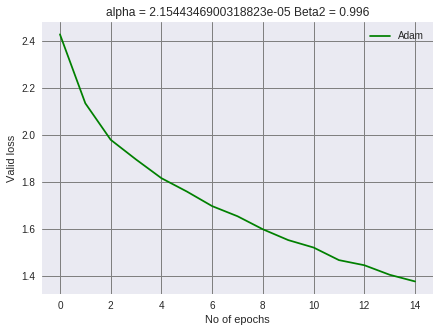

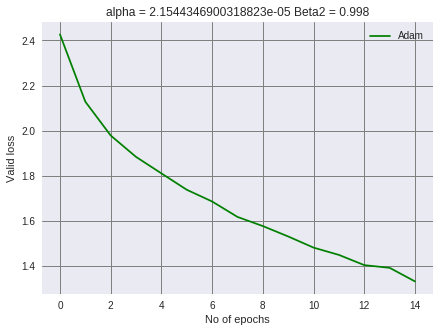

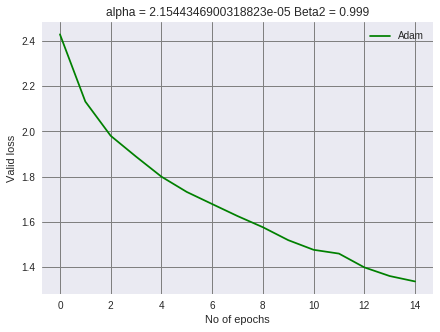

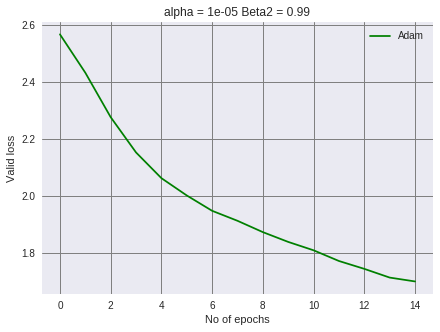

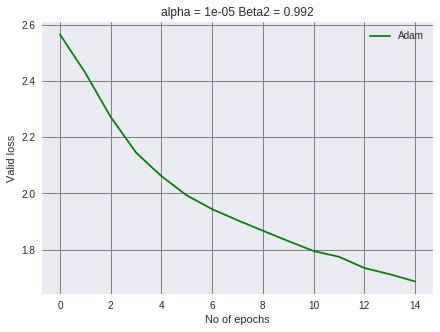

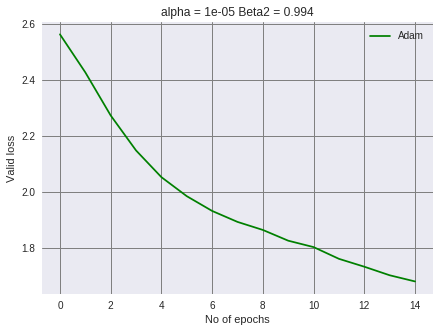

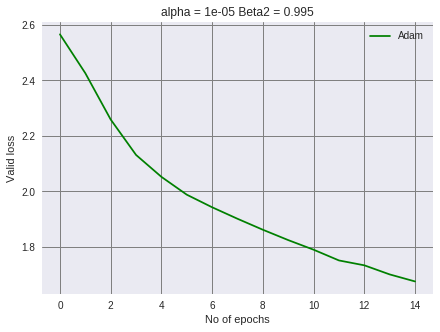

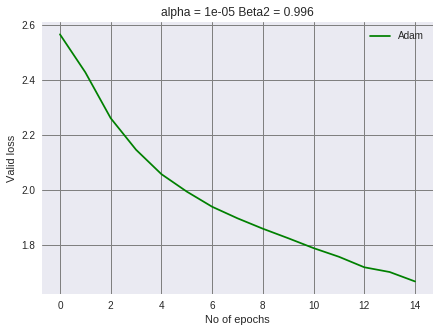

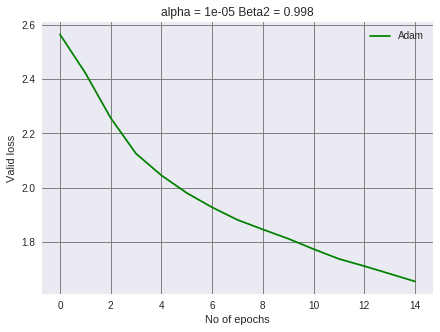

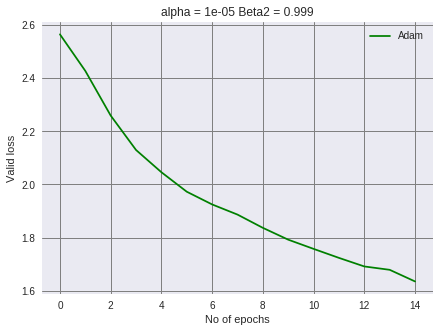

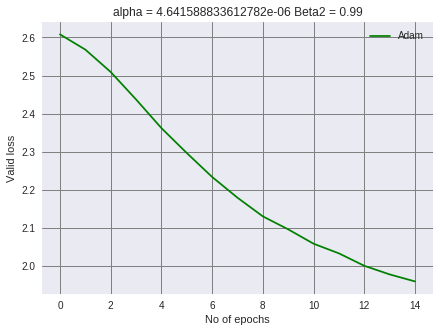

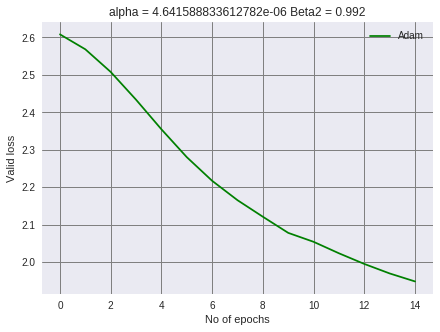

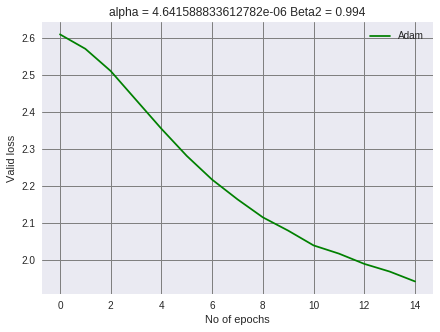

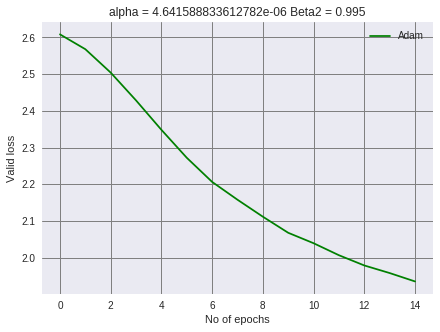

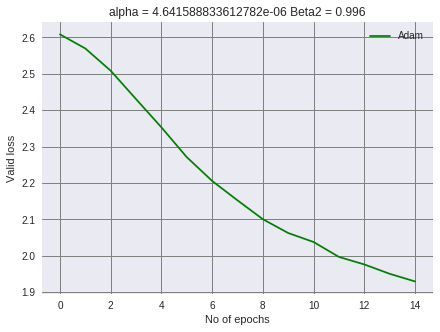

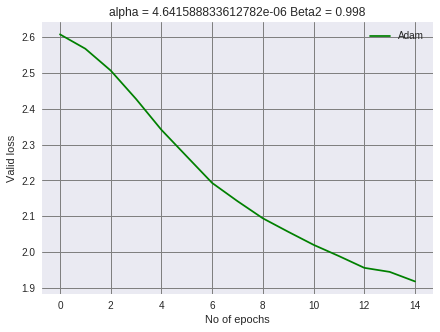

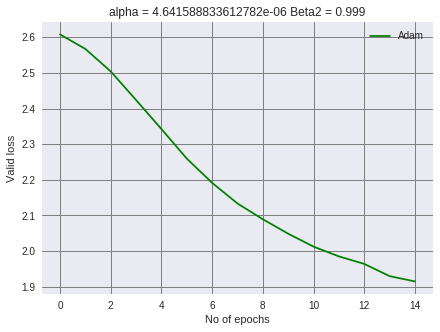

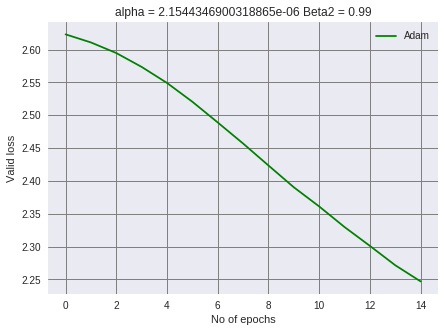

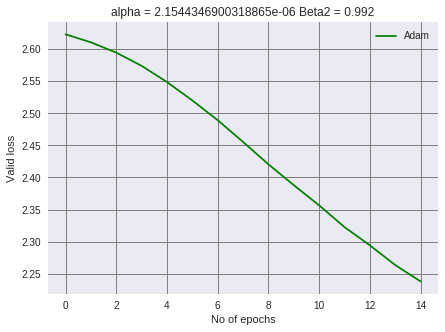

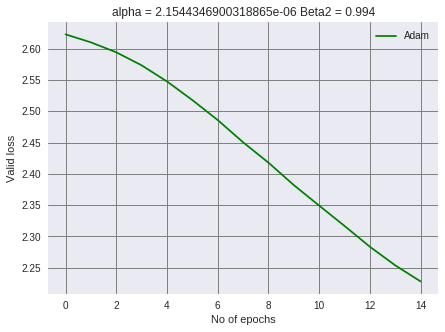

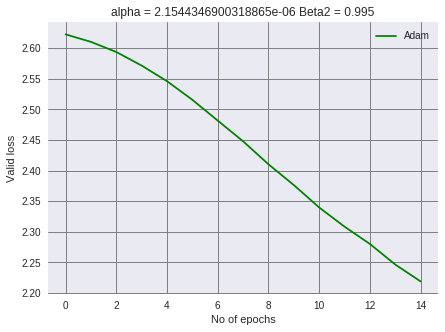

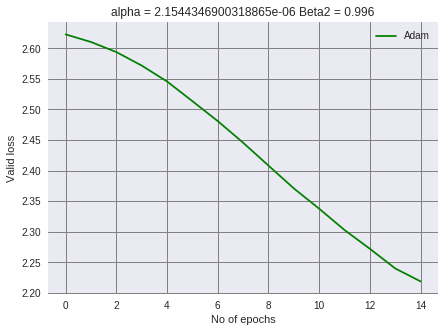

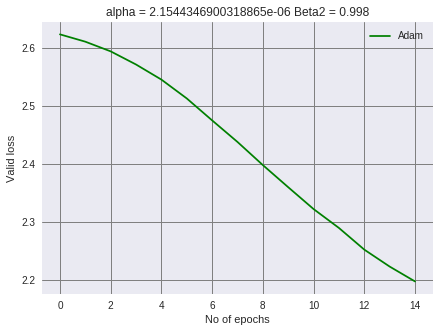

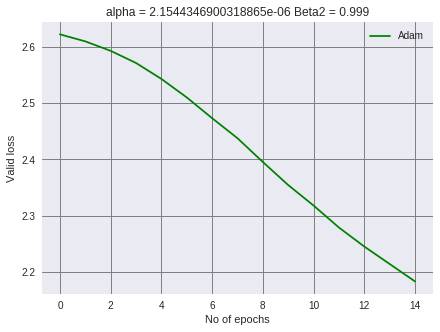

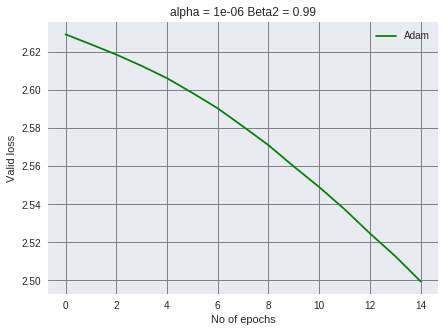

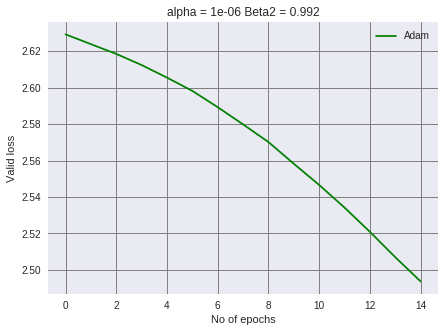

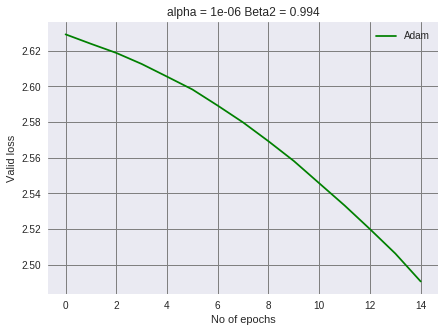

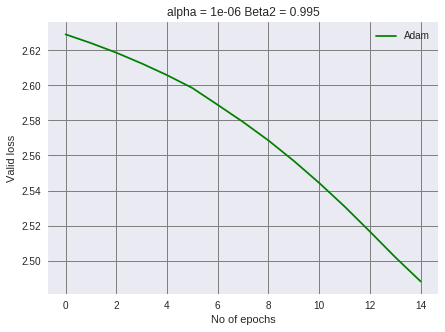

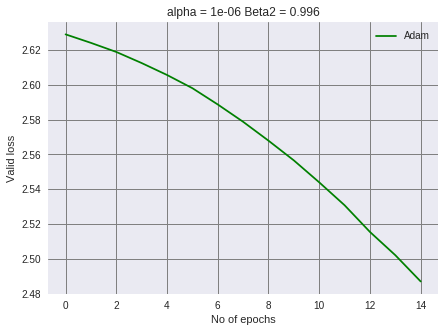

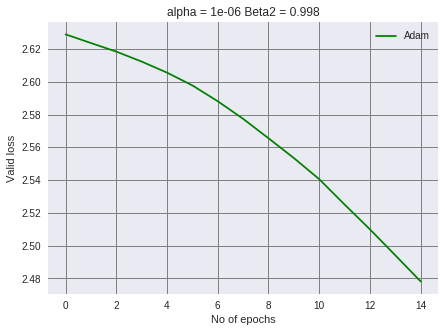

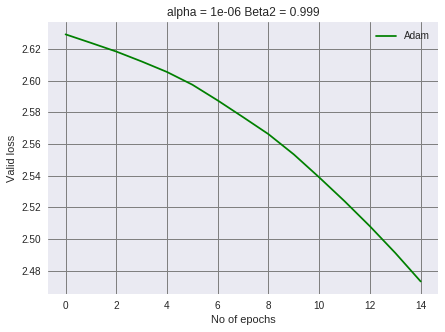

In [22]:
#Plotting validation loss vs number of iterations graph for every hyper-parameter combination for Adam
x = np.arange(0,num_epochs)
print(x)
for i in range(len(valid_loss_list_adam)):
  
  plt.figure(figsize=(7,5))
  title = "alpha = " + str(valid_loss_list_adam[i][1]) + " Beta2 = " + str(valid_loss_list_adam[i][2])
  plt.title(title)
  plt.plot(x, valid_loss_list_adam[i][0], 'g', label="Adam")
  plt.grid(color='gray', linewidth=1)
  plt.legend(loc='best')
  plt.xlabel('No of epochs')
  plt.ylabel('Valid loss')
  plt.show()

In [0]:
#Minimum validation loss was calculated for eachcombination  and  the  pair  which  resulted  in  least  validationloss with a non-increasing trajectory of validation loss withepochs was chosen as the best value for the hyper-parameters


min_valid_loss_adam = []
param_combo_count = 0   
for alpha_idx, alpha in enumerate(alphas):
  for beta_idx, beta in enumerate(betas):
    min_valid_for_alpha_beta = (min(valid_loss_list_adam[param_combo_count][0]))
    min_valid_loss_adam.append(min_valid_for_alpha_beta)
    param_combo_count += 1

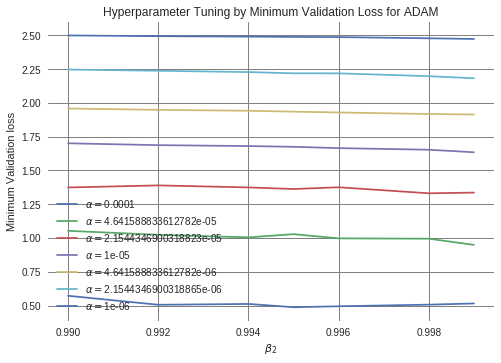

In [24]:
# Hyperparameter Tuning results by Minimum Validation Loss for ADAM
count = 0
title = "Hyperparameter Tuning by Minimum Validation Loss for ADAM"
plt.title(title)
for i , alpha in enumerate(alphas):
  plt.plot(betas, min_valid_loss_adam[count:count+len(betas)], label=r'$\alpha = $'+str(alpha))
  count += len(betas)
plt.gca().set_facecolor('w')
plt.grid(color='gray', linewidth=1)
plt.legend(loc='best')
#plt.ylim(0,2.7)
plt.xlabel(r'$\beta_2$')
plt.ylabel('Minimum Validation loss')
plt.show()

In [0]:
alpha_adam = 2.15443469e-05
beta2_adam = 0.998

In [0]:
net_adam.load_state_dict(initial_state)

In [0]:
# Learning the parameters using Amsgrad optimization with categorical cross-entropy loss. 
optimizer_adam = optim.Adam(net_adam.parameters(), lr=alpha_adam, betas=(0.9,beta2_adam))

In [37]:
#The code below runs for 25 epochs, learns the parameters of the model using Amsgrad optimizer with cross-entropy loss function 
#and propagates back the gradients in the network. It prints the train loss after every epoch and validation loss after each epoch.
train_loss_list_epoch_adam = []
test_loss_list_epoch_adam = []
train_loss_list_iter_adam = []
pkl_filename = 'nn_saved_model_adam.pkl'
num_epochs = 70
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss_train = 0.0
    for i, data in enumerate(trainloader_cifar_10, 0):
        running_loss = 0.0
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

        # zero the parameter gradients
        optimizer_adam.zero_grad()

        # forward + backward + optimize
        outputs = net_adam(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_adam.step()

        # print statistics
        running_loss_train += loss.data[0]
        running_loss = loss.data[0]
        train_loss_list_iter_adam.append(running_loss)
        
    train_loss = running_loss_train/num_batches_train
    test_loss = validation_loss(testloader_cifar_10, num_batches_test, net_adam,criterion)
    print ('Epoch: %d Train loss: %.3f' %(epoch + 1, train_loss))
    print ('Epoch: %d Test loss: %.3f' %(epoch + 1, test_loss))
    train_loss_list_epoch_adam.append(train_loss)
    test_loss_list_epoch_adam.append(test_loss)

    torch.save(net_adam.state_dict(), pkl_filename)

print('Finished Training')

Epoch: 1 Train loss: 1.720
Epoch: 1 Test loss: 1.448
Epoch: 2 Train loss: 1.346
Epoch: 2 Test loss: 1.287
Epoch: 3 Train loss: 1.215
Epoch: 3 Test loss: 1.196
Epoch: 4 Train loss: 1.121
Epoch: 4 Test loss: 1.129
Epoch: 5 Train loss: 1.047
Epoch: 5 Test loss: 1.077
Epoch: 6 Train loss: 0.990
Epoch: 6 Test loss: 1.034
Epoch: 7 Train loss: 0.942
Epoch: 7 Test loss: 1.004
Epoch: 8 Train loss: 0.902
Epoch: 8 Test loss: 0.976
Epoch: 9 Train loss: 0.867
Epoch: 9 Test loss: 0.952
Epoch: 10 Train loss: 0.835
Epoch: 10 Test loss: 0.953
Epoch: 11 Train loss: 0.805
Epoch: 11 Test loss: 0.935
Epoch: 12 Train loss: 0.779
Epoch: 12 Test loss: 0.917
Epoch: 13 Train loss: 0.752
Epoch: 13 Test loss: 0.901
Epoch: 14 Train loss: 0.729
Epoch: 14 Test loss: 0.897
Epoch: 15 Train loss: 0.705
Epoch: 15 Test loss: 0.884
Epoch: 16 Train loss: 0.683
Epoch: 16 Test loss: 0.880
Epoch: 17 Train loss: 0.661
Epoch: 17 Test loss: 0.882
Epoch: 18 Train loss: 0.640
Epoch: 18 Test loss: 0.876
Epoch: 19 Train loss: 0.620


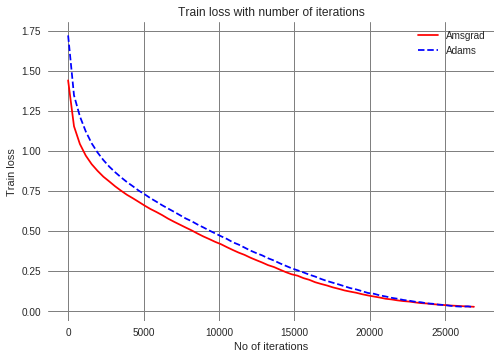

In [41]:
# Plotting the train loss with number of iterations for AMSGrad and Adam algorithm 
x = np.arange(0,num_epochs)
actual, = plt.plot(x*num_batches_train,train_loss_list_epoch, 'r-', label="Amsgrad")
predicted, = plt.plot(x*num_batches_train, train_loss_list_epoch_adam, 'b--', label ="Adams")
plt.gca().set_facecolor('w')
plt.grid(color='gray', linewidth=1)

plt.title("Train loss with number of iterations")
plt.legend(handles=[actual,predicted])
plt.xlabel('No of iterations')
plt.ylabel('Train loss')
plt.show()

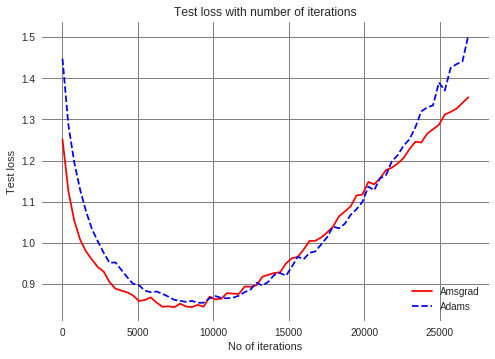

In [40]:
# Plotting the test loss with number of iterations for AMSGrad and Adam algorithm 
x = np.arange(0,num_epochs)
actual, = plt.plot(x*num_batches_train,test_loss_list_epoch, 'r-', label="Amsgrad")
predicted, = plt.plot(x*num_batches_train, test_loss_list_epoch_adam, 'b--', label ="Adams")
plt.gca().set_facecolor('w')
plt.grid(color='gray')
plt.title("Test loss with number of iterations")
plt.legend(handles=[actual,predicted])
plt.xlabel('No of iterations')
plt.ylabel('Test loss')
plt.show()
